# Health and Lifestyle Survey Questions Tutorial

In this tutorial, we showcase how the Protodash explainer algorithm from AI Explainability 360 Toolkit implemented through the _ProtodashExplainer_ class could be used to summarize the National Health and Nutrition Examination Survey (NHANES) datasets ([Study 1](#study1)) available through the Center for Disease Control and Prevention (CDC). Moreover, we also show how the algorithm could be used to distill interesting relationships between different facets of life (i.e. early childhood and income), which were found by scientists ([Study 2](#study2)) through decades of rigorous experimentation. This study shows that in using Protodash, one can potentially uncover such insights cheaply, which could then be reaffirmed through rigorous experimentation.

 Data from this survey is typically used in epidemiological studies and health science research, which helps develop public health policy, direct and design health programs and services, and expand health knowledge. Thus, the impact of understanding these datasets and the relationships that may exist between them are far reaching for a social scientist.

<a name="intro"></a>
## Introduction to Center for Disease Control and Prevention (CDC) datasets

The [NHANES CDC questionnaire datasets](https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Questionnaire&CycleBeginYear=2013) are surveys conducted by the organization involving thousands of civilians about various facets of their daily lives. There are 44 questionnaires that collect data about income, occupation, health, early childhood and many other behavioral and lifestyle aspects of individuals living in the US. These questionnaires are thus a rich source of information indicative of the quality of life of many civilians. 

This tutorial presents two studies. We first see how a CDC questionaire answered by thousands of individuals could be summarized by looking at answers given by a few prototypical users. Next, an interesting endeavor is to uncover relationships between different aspects of life by analyzing data across the different CDC questionnaires. In the second study, we do exactly that with the help of the Protodash explainer algorithm. We show how the algorithm is able to uncover an interesting [insight](https://www.theatlantic.com/business/archive/2016/07/social-mobility-america/491240/) known only through decades of experimentation, solely from the questionnaire datasets. This by no means suggests the method as a substitute for rigorous experimentation, but showcases it as an avenue for obtaining interesting insights at low cost, which could inspire further indepth studies. The manner in which this is accomplished is by finding prototypical individuals for each of the questionnaires and then evaluating how well they represent the income questionnaire (w.r.t. the method's objective function). The more representative these prototypes are, the more that questionnaire is indicative/representative of income. 

For this use case, we are selecting prototypes from specific questionnaires. Hence, the group we want to explain is the dataset itself, which — in this case — are the questionnaires. We are not training an AI model. Rather, we are trying to summarize each questionnaire, which was filled by thousands of people, by selecting a few representative individuals for each of them.


The rest of the tutorial is organized as follows: <br>
[Explore Income questionaire](#explore)<br>
[Study 1: Summarize Income Questionnaire using Prototypes](#study1)<br>
[Study 2: Find Questionnaire/s most representative of Income](#study2)<br>


###### [Protodash: Fast Interpretable Prototype Selection](https://arxiv.org/abs/1707.01212)

We now provide a brief overview of the method. The method takes as input a datapoint (or group of datapoints) that we want to explain with respect to instances in a training set belonging to the same feature space. The method then tries to minimize the maximum mean discrepancy (MMD metric) between the datapoints we want to explain and a prespecified number of instances from the training set that it will select. In other words, it will try to select training instances that have the same distribution as the datapoints we want to explain. The method does greedy selection and has quality guarantees with it also returning importance weights for the chosen prototypical training instances indicative of how similar/representative they are. 


###### Why Protodash?

Before we showcase the two studies, we provide some motivation for using this method. The method is able to select in a deterministic fashion examples from a dataset, which we term as prototypes that represent the different segments in a dataset. For example, if we take people that answered the income questionnaire, we might find that there are three categories of people: i) those that are high earners, ii) those that are middle class and iii) those that don't earn much or are unemployed and receive unemployment benefits. Protodash would be able to find these segments by pointing to specific individuals that lie in these categories. Looking at the objective function value of Protodash, one would also be able to say that three segments is the right number here as adding one more segment may not improve the objective value by much.

Compared with other methods such as k-medoids, it has the advantage that it is deterministic and does not have randomizations as in, say, k-medoids clustering, where the centers a typically randomly initialized. So the solutions are repeatable and it picks prototypes that are representative as well as diverse, which may not be the case with standard distance metrics such as euclidean distance. Diversity is important in practical settings (viz. income example above) where we want to capture all the different segments/modes in the dataset, not missing any of the key behaviors.

Another benefit of the method is that, since it performs distribution matching between the user/users in question and those available in the training set, it could, in principle, also be applied in non-iid settings such as for time series data. Other approaches which find similar profiles using standard distance measures (viz. euclidean, cosine) do not have this property. Additionally, we can also highlight important features for the different prototypes that made them similar to the user/users in question.

#### Import Statements

Import relevant libraries, datasets and Protodash explainer algorithm.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

from aix360.algorithms.protodash import ProtodashExplainer
from aix360.datasets.cdc_dataset import CDCDataset

Using TensorFlow backend.


#### Load CDC dataset

In [2]:
nhanes = CDCDataset()
nhanes_files = nhanes.get_csv_file_names()
(nhanesinfo, _, _) = nhanes._cdc_files_info()

<a name="explore"></a>
## Explore Income questionnaire

Now let us explore the income questionnaire dataset and find out the types of responses received in the survey. Each column in the dataset corresponds to a question and each row denotes the answers given by a respondent to those questions. Both column names and answers by respondents are encoded. For example, 'SEQN' denotes the sequence number assigned to a respondent and 'IND235' corresponds to a question about monthly family income. As seen below, in most cases a value of 1 implies "Yes" to the question, while a value of 2 implies "No." More details about the income questionaire and how questions and answers are encoded can be seen [here](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/INQ_H.htm)

|Column  |Description                    | Values and Meaning|
|-------|----------------------------|---------|
|SEQN   | Respondent sequence number |
|INQ020 | Income from wages/salaries |1->Yes, 2->No, 7->Refused, 9->Don't know|
|INQ012 | Income from self employment|1->Yes, 2->No, 7->Refused, 9->Don't know|
|INQ030 | Income from Social Security or RR |1->Yes, 2->No, 7->Refused, 9->Don't know|
|INQ060 | Income from other disability pension |1->Yes, 2->No, 7->Refused, 9->Don't know|
|INQ080 | Income from retirement/survivor pension |1->Yes, 2->No, 7->Refused, 9->Don't know|
|INQ090 | Income from Supplemental Security Income |1->Yes, 2->No, 7->Refused, 9->Don't know|
|INQ132 | Income from state/county cash assistance |1->Yes, 2->No, 7->Refused, 9->Don't know|
|INQ140 | Income from interest/dividends or rental |1->Yes, 2->No, 7->Refused, 9->Don't know|
|INQ150 | Income from other sources |1->Yes, 2->No, 7->Refused, 9->Don't know|
|IND235 | Monthly family income |1-12->Increasing income brackets, 77->Refused, 99->Don't know|
|INDFMMPI | Family monthly poverty level index |0-5->Higher value more affluent|
|INDFMMPC | Family monthly poverty level category |1-3->Increasing INDFMMPI brackets, 7->Refused, 9->Don't know|
|INQ244 | Family has savings more than $5000 |1->Yes, 2->No, 7->Refused, 9->Don't know|
|IND247 | Total savings/cash assets for the family |1-6->Increasing savings brackets, 77->Refused, 99->Don't know|

In [3]:
# replace encoded column names by the associated question text. 
df_inc = nhanes.get_csv_file('INQ_H.csv')
df_inc.columns[0]
dict_inc = {
'SEQN': 'Respondent sequence number', 
'INQ020': 'Income from wages/salaries',
'INQ012': 'Income from self employment',
'INQ030':'Income from Social Security or RR',
'INQ060':  'Income from other disability pension', 
'INQ080':  'Income from retirement/survivor pension',
'INQ090':  'Income from Supplemental Security Income',
'INQ132':  'Income from state/county cash assistance', 
'INQ140':  'Income from interest/dividends or rental', 
'INQ150':  'Income from other sources',
'IND235':  'Monthly family income',
'INDFMMPI':  'Family monthly poverty level index', 
'INDFMMPC':  'Family monthly poverty level category',
'INQ244':  'Family has savings more than $5000',
'IND247':  'Total savings/cash assets for the family'
}
qlist = []
for i in range(len(df_inc.columns)):
    qlist.append(dict_inc[df_inc.columns[i]])
df_inc.columns = qlist
print("Answers given by some respondents to the income questionnaire:")
df_inc.head(5).transpose()

Answers given by some respondents to the income questionnaire:


,0,1,2,3,4
Respondent sequence number,73557.00,73558.00,73559.00,73560.00,73561.0
Income from wages/salaries,2.00,1.00,2.00,1.00,2.0
Income from self employment,2.00,1.00,2.00,2.00,2.0
Income from Social Security or RR,1.00,1.00,1.00,2.00,1.0
Income from other disability pension,2.00,2.00,2.00,2.00,2.0
Income from retirement/survivor pension,2.00,2.00,1.00,2.00,2.0
Income from Supplemental Security Income,2.00,2.00,2.00,2.00,2.0
Income from state/county cash assistance,2.00,2.00,2.00,2.00,2.0
Income from interest/dividends or rental,2.00,1.00,1.00,2.00,2.0
Income from other sources,2.00,2.00,2.00,1.00,2.0


Now, to get more of a feel for the dataset, let us look at the distribution of responses for two questions related to family financial status.

Number of respondents to Income questionnaire: 10175
Distribution of answers to 'monthly family income' and 'Family savings' questions:


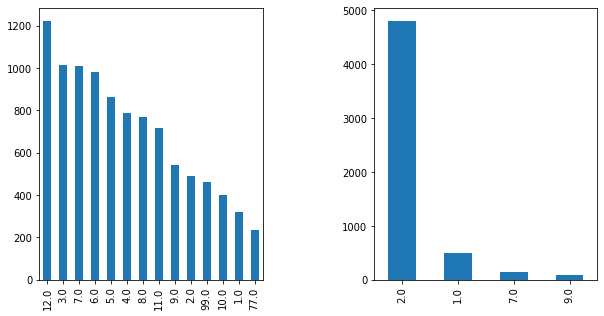

In [4]:
print("Number of respondents to Income questionnaire:", df_inc.shape[0])
print("Distribution of answers to \'monthly family income\' and \'Family savings\' questions:")

fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.subplots_adjust(wspace=0.5)
hist1 = df_inc['Monthly family income'].value_counts().plot(kind='bar', ax=axes[0])
hist2 = df_inc['Family has savings more than $5000'].value_counts().plot(kind='bar', ax=axes[1])
plt.show()

<a name="Dplot"></a>
Observe that the majority of individuals responded with a "12" o the question related to monthly family income, which means their income is above USD 8400 as explained [here](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/INQ_H.htm#IND235). Similarly, to the question of whether the family has savings more than USD 5000, the majority of individuals responded with a "2", which means "No". 

<a name="study1"></a>
## Study 1: Summarize Income Questionnaire using Prototypes

We just explored the income dataset and looked at the distribution of answers for a couple of questions. Now, consider a social scientist who would like to quickly obtain a summary report of this dataset in terms of types of people that span this dataset. Is it possible to summarize this dataset by looking at answers given by a few representative/prototypical respondents? 

We now show how the Protodash algorithm can be used to obtain a few prototypical respondents (about 10 in this example) that span the diverse set of individuals answering the income questionnaire making it easy for the social scientist to summarize the dataset.

In [5]:
# convert pandas dataframe to numpy
data = df_inc.to_numpy()

#sort the rows by sequence numbers in 1st column 
idx = np.argsort(data[:, 0])  
data = data[idx, :]

# replace nan's (missing values) with 0's
original = data
original[np.isnan(original)] = 0

# delete 1st column (sequence numbers)
original = original[:, 1:]

# one hot encode all features as they are categorical
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(original)

explainer = ProtodashExplainer()

# call Protodash explainer
# S contains indices of the selected prototypes
# W contains importance weights associated with the selected prototypes 
(W, S, _) = explainer.explain(onehot_encoded, onehot_encoded, m=10) 

# sort the order of prototypes in set S
idx = np.argsort(S)
S = S[idx]
W = W[idx]

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  3.6019e+01 -4.3677e+05  9e+01  1e+00  1e+00
 2:  2.8664e+00 -2.0364e+06  5e+02  1e+00  1e+00
 3:  1.6848e+01 -1.1632e+08  2e+04  1e+00  1e+00
 4:  3.5425e+01 -8.8167e+10  2e+07  1e+00  1e+00
 5:  1.9393e+05 -1.6204e+18  2e+18  2e-13  5e-03
 6:  1.9393e+05 -1.6204e+16  2e+16  2e-15  1e-03
 7:  1.9393e+05 -1.6204e+14  2e+14  4e-17  5e-06
 8:  1.9393e+05 -1.6204e+12  2e+12  2e-16  1e-07
 9:  1.9391e+05 -1.6204e+10  2e+10  1e-16  2e-09
10:  1.9189e+05 -1.6252e+08  2e+08  1e-16  2e-11
11:  9.7644e+04 -1.8416e+06  2e+06  1e-17  2e-13
12:  1.4907e+04 -3.3612e+04  5e+04  3e-16  1e-14
13:  2.1069e+03 -2.4523e+03  5e+03  1e-16  5e-15
14:  2.8232e+02 -3.7496e+02  7e+02  8e-17  2e-15
15:  3.1901e+01 -6.1651e+01  9e+01  4e-17  2e-15
16:  9.7377e-02 -1.2756e+01  1e+01  2e-16  6e-16
17: -3.2505e+00 -4.7374e+00  1e+00  5e-16  2e-16
18: -3.5543e+00 -3.7268e+00  2e-01  1e-16  2e-16
19: -3.5627e+00 -3.56

In [6]:
# Display the prototypes along with their computed weights
inc_prototypes = df_inc.iloc[S, :].copy()
# Compute normalized importance weights for prototypes
inc_prototypes["Weights of Prototypes"] = np.around(W/np.sum(W), 2) 
inc_prototypes.transpose()

,8,132,690,1475,2449,2912,3899,5077,6895,7475
Respondent sequence number,73565.00,73689.00,74247.00,75032.00,76006.00,76469.00,77456.00,78634.00,80452.00,81032.00
Income from wages/salaries,1.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00
Income from self employment,2.00,2.00,2.00,2.00,1.00,2.00,2.00,2.00,2.00,2.00
Income from Social Security or RR,2.00,2.00,2.00,2.00,2.00,2.00,1.00,2.00,2.00,1.00
Income from other disability pension,2.00,2.00,2.00,2.00,2.00,1.00,2.00,2.00,2.00,2.00
Income from retirement/survivor pension,2.00,2.00,2.00,2.00,2.00,1.00,2.00,1.00,2.00,2.00
Income from Supplemental Security Income,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,2.00
Income from state/county cash assistance,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,2.00
Income from interest/dividends or rental,2.00,1.00,2.00,1.00,2.00,2.00,2.00,2.00,2.00,1.00
Income from other sources,2.00,2.00,2.00,2.00,1.00,2.00,2.00,2.00,2.00,2.00


#### Explanation:
The 10 people shown above (i.e. 10 prototypes) are representative of the income questionnaire according to Protodash. Firstly, in the distribution plot for family finance related questions, we saw that there roughly were five times as many people not having savings in excess of $5000 compared with others. Our prototypes also have a similar spread, which is reassuring. Also, for monthly family income, we get a more even spread over the more commonly occurring categories. This is a kind of spot check to see if our prototypes actually match the distribution of values in the dataset.

Looking at the other questions in the questionnaire and the corresponding answers given by the prototypical people above, the social scientist realizes that most people are employed (3rd question) and work for an organization earning through salary/wages (1st two questions). Most of them are also young (5th question) and fit to work (4th question). However, they don't seem to have much savings (last question). The insights that the social scientist acquired from studying the prototypes could also be conveyed to the appropriate government authorities that affect future public policy decisions.

<a name="study2"></a>
## Study 2: Find Questionnaire/s that are most representative of Income

We now move on to our second study, where we want to see how the remaining 39 questionnaires represent or relate to income. This will provide us with an idea of which lifestyle factors are likely to affect income the most. To do this we compute prototypes for each of the questionnaires and evaluate how well they represent the income questionnaire relative to our objective function. 

#### Compute prototypes for all questionaires

This step uses Protodash explainer to compute 10 prototypes for each of the questionaires and saves these for  further evaluation. 

In [7]:
# Iterate through all questionnaire datasets and find 10 prototypes for each.

prototypes = {}

for i in range(len(nhanes_files)):
    
    f = nhanes_files[i]
    
    print("processing ", f)
    
    # read data to pandas dataframe
    df = nhanes.get_csv_file(f)
    
    # convert data to numpy
    data = df.to_numpy()

    #sort the rows by sequence numbers in 1st column 
    idx = np.argsort(data[:, 0])
    data = data[idx, :]

    # replace nan's with 0's.
    original = data
    original[np.isnan(original)] = 0

    # delete 1st column (contains sequence numbers)
    original = original[:, 1:]

    # one hot encode all features as they are categorical
    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoded = onehot_encoder.fit_transform(original)

    explainer = ProtodashExplainer()

    # call Protodash explainer
    # S contains indices of the selected prototypes
    # W contains importance weights associated with the selected prototypes 

    (W, S, _) = explainer.explain(onehot_encoded, onehot_encoded, m=10) 

    prototypes[f]={}
    prototypes[f]['W']= W
    prototypes[f]['S']= S
    prototypes[f]['data'] = data
    prototypes[f]['original'] = original

processing  ACQ_H.csv
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  1.5310e+01 -2.0066e+05  4e+01  1e+00  1e+00
 2:  2.2661e-01 -2.9693e+06  6e+02  1e+00  1e+00
 3:  4.5958e+00 -4.9296e+08  1e+05  1e+00  1e+00
 4:  2.5900e+06 -1.1503e+16  1e+16  4e-13  2e-05
 5:  2.5900e+06 -1.1503e+14  1e+14  4e-15  1e-05
 6:  2.5900e+06 -1.1503e+12  1e+12  9e-17  3e-07
 7:  2.5892e+06 -1.1510e+10  1e+10  1e-16  4e-09
 8:  2.5107e+06 -1.2228e+08  1e+08  1e-16  5e-11
 9:  7.7656e+05 -2.8694e+06  4e+06  3e-16  2e-12
10:  1.1690e+05 -1.4468e+05  3e+05  4e-16  2e-13
11:  1.6636e+04 -1.8584e+04  4e+04  3e-16  2e-14
12:  2.3433e+03 -2.7242e+03  5e+03  2e-16  2e-14
13:  3.1920e+02 -4.0603e+02  7e+02  3e-16  6e-15
14:  3.8823e+01 -6.4788e+01  1e+02  2e-16  3e-16
15:  2.2958e+00 -1.2253e+01  1e+01  2e-16  6e-16
16: -1.6449e+00 -3.4574e+00  2e+00  2e-16  2e-16
17: -1.8754e+00 -2.1093e+00  2e-01  3e-16  1e-16
18: -1.8873e+00 -1.8948e+00  7e-03  4e-16  6e-17

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  2.0819e+01 -2.7904e+05  6e+01  1e+00  1e+00
 2:  2.4817e+00 -2.3206e+06  5e+02  1e+00  1e+00
 3:  8.4644e+00 -2.3998e+08  5e+04  1e+00  1e+00
 4:  2.0332e+01 -6.0208e+11  2e+08  1e+00  1e+00
 5:  1.0172e+05 -6.3132e+18  6e+18  2e-13  3e-03
 6:  1.0172e+05 -6.3132e+16  6e+16  2e-15  5e-03
 7:  1.0172e+05 -6.3132e+14  6e+14  1e-17  9e-05
 8:  1.0172e+05 -6.3132e+12  6e+12  3e-16  7e-07
 9:  1.0172e+05 -6.3132e+10  6e+10  2e-16  2e-08
10:  1.0156e+05 -6.3158e+08  6e+08  5e-17  3e-10
11:  8.7842e+04 -6.5407e+06  7e+06  3e-16  2e-12
12:  1.6187e+04 -8.5337e+04  1e+05  7e-17  6e-14
13:  2.3426e+03 -3.1523e+03  5e+03  2e-16  1e-14
14:  3.2166e+02 -3.9112e+02  7e+02  2e-16  6e-15
15:  4.0566e+01 -6.2142e+01  1e+02  2e-16  1e-15
16:  3.0790e+00 -1.1323e+01  1e+01  3e-16  6e-16
17: -1.4077e+00 -3.2217e+00  2e+00  2e-16  1e-16
18: -1.8915e+00 -2.1302e+00  2e-01  2e-16  6e-17
19: -1.9228e+00 -1.93

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -9.0000e+04  2e+01  1e+00  1e+00
 1:  6.4839e+01 -1.8426e+06  3e+02  1e+00  1e+00
 2:  1.2545e+02 -3.0769e+06  6e+02  1e+00  1e+00
 3:  1.5639e+02 -6.9902e+06  1e+03  1e+00  1e+00
 4:  5.4910e+00 -1.0972e+08  2e+04  1e+00  1e+00
 5:  8.4172e+00 -1.3955e+09  3e+05  1e+00  1e+00
 6:  1.7279e+01 -2.4754e+11  5e+07  1e+00  1e+00
 7:  2.7190e+09 -5.6892e+18  6e+18  3e-13  4e-03
 8:  2.7190e+09 -5.6892e+16  6e+16  3e-15  2e-03
 9:  2.7190e+09 -5.6894e+14  6e+14  2e-16  3e-05
10:  2.7189e+09 -5.7075e+12  6e+12  2e-16  3e-07
11:  2.7124e+09 -7.5157e+10  8e+10  1e-16  5e-09
12:  2.3373e+09 -1.6397e+10  2e+10  1e-16  2e-09
13:  6.1484e+08 -1.5372e+10  2e+10  1e-16  1e-09
14:  2.8807e+08 -1.3473e+09  2e+09  1e-16  1e-10
15:  5.2378e+07 -7.2505e+07  1e+08  1e-16  2e-12
16:  7.5720e+06 -8.4050e+06  2e+07  2e-16  1e-12
17:  1.0874e+06 -1.2113e+06  2e+06  2e-16  4e-13
18:  1.5563e+05 -1.7272e+05  3e+05  1e-16  1e-13
19:  2.2180e+04 -2.48

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -6.0000e+04  1e+01  1e+00  1e+00
 1:  7.2987e+01 -1.4841e+06  3e+02  1e+00  1e+00
 2:  9.9693e+01 -2.6227e+06  5e+02  1e+00  1e+00
 3:  1.7730e+01 -1.3186e+07  3e+03  1e+00  1e+00
 4:  4.5630e+01 -8.8193e+07  2e+04  1e+00  1e+00
 5:  5.9928e+01 -7.8164e+09  2e+06  1e+00  1e+00
 6:  4.3515e+08 -1.8730e+17  2e+17  6e-13  1e-04
 7:  4.3515e+08 -1.8730e+15  2e+15  6e-15  6e-05
 8:  4.3515e+08 -1.8735e+13  2e+13  2e-16  5e-07
 9:  4.3499e+08 -1.9155e+11  2e+11  2e-16  1e-08
10:  4.2008e+08 -5.9750e+09  6e+09  2e-16  4e-10
11:  1.0679e+08 -7.0548e+08  8e+08  2e-16  3e-10
12:  2.2779e+07 -4.0740e+07  6e+07  1e-16  1e-11
13:  3.3061e+06 -3.5941e+06  7e+06  1e-16  2e-13
14:  4.7484e+05 -5.3245e+05  1e+06  3e-16  3e-13
15:  6.7870e+04 -7.5673e+04  1e+05  1e-16  1e-13
16:  9.6368e+03 -1.0919e+04  2e+04  2e-16  3e-14
17:  1.3449e+03 -1.5991e+03  3e+03  9e-17  1e-14
18:  1.7801e+02 -2.4328e+02  4e+02  1e-16  6e-15
19:  1.8870e+01 -4.09

18: -5.6187e+00 -1.4299e+01  9e+00  2e-16  3e-16
19: -6.8532e+00 -7.6986e+00  8e-01  2e-16  9e-17
20: -6.9081e+00 -7.0098e+00  1e-01  2e-16  5e-17
21: -6.9087e+00 -6.9099e+00  1e-03  1e-16  5e-17
22: -6.9087e+00 -6.9087e+00  1e-05  2e-16  5e-17
23: -6.9087e+00 -6.9087e+00  1e-07  6e-17  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -3.0000e+04  6e+00  1e+00  1e+00
 1:  6.2936e+01 -9.0373e+05  2e+02  1e+00  1e+00
 2:  6.0998e+01 -1.5613e+06  3e+02  1e+00  1e+00
 3:  4.9090e+00 -2.1900e+07  4e+03  1e+00  1e+00
 4:  1.3503e+01 -2.8912e+08  6e+04  1e+00  1e+00
 5:  1.5151e+01 -5.9076e+10  1e+07  1e+00  1e+00
 6:  7.7427e+08 -1.3433e+18  1e+18  4e-13  5e-04
 7:  7.7427e+08 -1.3433e+16  1e+16  4e-15  7e-04
 8:  7.7427e+08 -1.3434e+14  1e+14  6e-17  1e-05
 9:  7.7426e+08 -1.3471e+12  1e+12  2e-16  7e-08
10:  7.7345e+08 -1.7228e+10  2e+10  3e-16  1e-09
11:  7.1200e+08 -3.6084e+09  4e+09  4e-16  3e-10
12:  3.6195e+07 -4.1086e+09  4e+09  3e-16  2e-

 7:  6.2627e+08 -4.7974e+09  5e+09  9e-17  6e-10
 8:  3.1614e+08 -7.0394e+08  1e+09  1e-16  9e-11
 9:  5.0353e+07 -9.6612e+07  1e+08  3e-16  6e-13
10:  8.0103e+06 -8.8470e+06  2e+07  2e-16  4e-13
11:  1.1533e+06 -1.3042e+06  2e+06  3e-16  3e-13
12:  1.6506e+05 -1.8422e+05  3e+05  9e-17  1e-13
13:  2.3467e+04 -2.6539e+04  5e+04  3e-16  3e-14
14:  3.2853e+03 -3.8758e+03  7e+03  2e-16  1e-14
15:  4.3969e+02 -5.8556e+02  1e+03  1e-16  5e-15
16:  4.9751e+01 -9.6435e+01  1e+02  2e-16  2e-15
17:  5.2293e-01 -1.9722e+01  2e+01  6e-17  4e-16
18: -4.2841e+00 -6.5770e+00  2e+00  2e-17  4e-16
19: -4.5115e+00 -4.6955e+00  2e-01  1e-16  2e-17
20: -4.5190e+00 -4.5214e+00  2e-03  2e-16  5e-17
21: -4.5190e+00 -4.5191e+00  2e-05  1e-16  4e-17
22: -4.5190e+00 -4.5190e+00  2e-07  5e-17  7e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -3.0000e+04  6e+00  1e+00  1e+00
 1:  6.5803e+01 -9.8251e+05  2e+02  1e+00  1e+00
 2:  5.7106e+01 -1.9330e+06  4e+02  1e+00  1e+

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -9.0000e+04  2e+01  1e+00  1e+00
 1:  1.0860e+02 -3.4844e+06  5e+02  1e+00  1e+00
 2:  4.4201e+02 -8.3118e+06  2e+03  1e+00  1e+00
 3:  2.4636e+01 -2.2987e+07  5e+03  1e+00  1e+00
 4:  2.9659e+01 -6.4911e+07  1e+04  1e+00  1e+00
 5:  7.6624e+01 -3.0893e+08  6e+04  1e+00  1e+00
 6:  1.7241e+02 -8.2157e+09  2e+06  1e+00  1e+00
 7:  2.4734e+02 -2.7488e+13  9e+09  1e+00  1e+00
 8:  4.4115e+08 -2.4048e+20  2e+20  4e-13  3e-01
 9:  4.4115e+08 -2.4048e+18  2e+18  4e-15  3e-02
10:  4.4115e+08 -2.4048e+16  2e+16  2e-16  4e-04
11:  4.4115e+08 -2.4048e+14  2e+14  2e-16  5e-06
12:  4.4110e+08 -2.4062e+12  2e+12  2e-16  4e-08
13:  4.3618e+08 -2.5509e+10  3e+10  1e-16  4e-10
14:  2.1885e+08 -9.2911e+08  1e+09  2e-16  6e-08
15:  3.5077e+07 -4.6504e+07  8e+07  2e-16  1e-09
16:  5.0351e+06 -5.5624e+06  1e+07  2e-16  6e-13
17:  7.2163e+05 -8.0248e+05  2e+06  2e-16  2e-13
18:  1.0302e+05 -1.1494e+05  2e+05  2e-16  6e-14
19:  1.4597e+04 -1.66

     pcost       dcost       gap    pres   dres
 0: -0.0000e+00 -8.0000e+04  2e+01  1e+00  1e+00
 1:  3.2360e+01 -9.0640e+05  2e+02  1e+00  1e+00
 2:  6.4912e+01 -1.9073e+06  4e+02  1e+00  1e+00
 3:  3.6762e+00 -2.3686e+07  5e+03  1e+00  1e+00
 4:  1.0071e+01 -2.6297e+08  5e+04  1e+00  1e+00
 5:  2.4368e+01 -4.6823e+10  1e+07  1e+00  1e+00
 6:  4.4448e+08 -1.0796e+18  1e+18  4e-13  2e-03
 7:  4.4448e+08 -1.0796e+16  1e+16  4e-15  1e-03
 8:  4.4448e+08 -1.0797e+14  1e+14  1e-16  2e-05
 9:  4.4447e+08 -1.0836e+12  1e+12  1e-16  2e-07
10:  4.4290e+08 -1.4723e+10  2e+10  2e-16  4e-09
11:  3.7141e+08 -3.5366e+09  4e+09  1e-16  2e-09
12:  1.3859e+08 -2.6089e+09  3e+09  2e-16  6e-10
13:  4.5784e+07 -1.1121e+08  2e+08  2e-16  3e-11
14:  6.9989e+06 -7.9099e+06  1e+07  2e-16  2e-12
15:  1.0059e+06 -1.1224e+06  2e+06  2e-16  5e-13
16:  1.4417e+05 -1.5966e+05  3e+05  2e-16  2e-13
17:  2.0605e+04 -2.2900e+04  4e+04  2e-16  8e-14
18:  2.9286e+03 -3.3034e+03  6e+03  3e-16  3e-14
19:  4.1016e+02 -4.82

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -5.0000e+04  1e+01  1e+00  1e+00
 1:  4.6263e+01 -8.0301e+05  2e+02  1e+00  1e+00
 2:  6.9155e+00 -3.6493e+06  8e+02  1e+00  1e+00
 3:  1.3243e+01 -1.3187e+07  3e+03  1e+00  1e+00
 4:  2.2244e+01 -1.9195e+08  4e+04  1e+00  1e+00
 5:  2.7988e+01 -7.1861e+10  2e+07  1e+00  1e+00
 6:  2.1186e+08 -1.5386e+18  2e+18  8e-13  2e-03
 7:  2.1186e+08 -1.5386e+16  2e+16  8e-15  1e-03
 8:  2.1186e+08 -1.5386e+14  2e+14  2e-16  2e-05
 9:  2.1186e+08 -1.5401e+12  2e+12  1e-16  2e-07
10:  2.1145e+08 -1.6889e+10  2e+10  2e-16  3e-09
11:  1.7892e+08 -1.4193e+09  2e+09  1e-16  4e-10
12:  3.6418e+07 -1.8084e+08  2e+08  2e-16  9e-11
13:  7.0521e+06 -1.0393e+07  2e+07  2e-16  3e-12
14:  1.0187e+06 -1.1191e+06  2e+06  1e-16  4e-13
15:  1.4610e+05 -1.6334e+05  3e+05  1e-16  1e-13
16:  2.0847e+04 -2.3332e+04  4e+04  8e-17  4e-14
17:  2.9475e+03 -3.3794e+03  6e+03  2e-16  2e-14
18:  4.0637e+02 -4.9968e+02  9e+02  2e-16  1e-14
19:  5.1560e+01 -7.79

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  2.1228e+01 -2.7904e+05  6e+01  1e+00  1e+00
 2:  2.0751e+00 -2.3196e+06  5e+02  1e+00  1e+00
 3:  8.2702e+00 -2.3121e+08  5e+04  1e+00  1e+00
 4:  2.0880e+01 -7.2660e+11  2e+08  1e+00  1e+00
 5:  5.0473e+04 -6.4764e+18  6e+18  1e-13  8e-03
 6:  5.0473e+04 -6.4764e+16  6e+16  1e-15  4e-03
 7:  5.0473e+04 -6.4764e+14  6e+14  1e-16  6e-05
 8:  5.0473e+04 -6.4764e+12  6e+12  1e-16  1e-06
 9:  5.0473e+04 -6.4764e+10  6e+10  2e-16  1e-08
10:  5.0422e+04 -6.4776e+08  6e+08  3e-16  1e-10
11:  4.5797e+04 -6.5824e+06  7e+06  6e-17  3e-13
12:  9.2292e+03 -7.7719e+04  9e+04  8e-17  1e-14
13:  1.3277e+03 -2.1156e+03  3e+03  6e-17  1e-14
14:  1.7748e+02 -2.2780e+02  4e+02  2e-16  6e-15
15:  2.0387e+01 -3.8306e+01  6e+01  2e-16  2e-15
16:  3.3083e-01 -7.7586e+00  8e+00  5e-17  1e-15
17: -1.7893e+00 -2.6966e+00  9e-01  2e-16  2e-16
18: -1.9895e+00 -2.1013e+00  1e-01  1e-16  4e-17
19: -1.9977e+00 -2.00

processing  DEQ_H.csv
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  1.2931e+01 -2.0067e+05  4e+01  1e+00  1e+00
 2:  2.6698e+00 -2.9933e+06  6e+02  1e+00  1e+00
 3:  7.7626e+00 -8.4937e+08  2e+05  1e+00  1e+00
 4:  8.6894e+06 -1.8983e+16  2e+16  4e-13  4e-05
 5:  8.6894e+06 -1.8983e+14  2e+14  3e-15  6e-05
 6:  8.6893e+06 -1.8984e+12  2e+12  2e-16  9e-07
 7:  8.6857e+06 -1.9009e+10  2e+10  6e-17  1e-08
 8:  8.3425e+06 -2.1439e+08  2e+08  2e-16  2e-10
 9:  2.3418e+06 -6.6958e+06  9e+06  6e-18  5e-12
10:  3.5064e+05 -3.9548e+05  7e+05  6e-17  1e-13
11:  5.0223e+04 -5.6046e+04  1e+05  1e-16  9e-14
12:  7.1541e+03 -8.0522e+03  2e+04  2e-16  4e-14
13:  1.0062e+03 -1.1721e+03  2e+03  1e-16  3e-14
14:  1.3654e+02 -1.7546e+02  3e+02  3e-16  6e-15
15:  1.6349e+01 -2.8219e+01  4e+01  2e-16  3e-15
16:  7.9859e-01 -5.4442e+00  6e+00  2e-16  1e-15
17: -8.4106e-01 -1.6055e+00  8e-01  2e-16  4e-16
18: -9.2776e-01 -9.6791e-01  4e-02  1e-16  1e-16

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  1.5722e+02 -1.6435e+06  3e+02  1e+00  1e+00
 2:  8.0292e-01 -3.9079e+06  1e+03  1e+00  1e+00
 3:  7.7141e+01 -1.1060e+08  2e+04  1e+00  1e+00
 4:  1.5484e+02 -2.7101e+10  6e+06  1e+00  1e+00
 5:  1.4730e+06 -6.0530e+17  6e+17  5e-13  1e-04
 6:  1.4730e+06 -6.0530e+15  6e+15  5e-15  2e-04
 7:  1.4730e+06 -6.0530e+13  6e+13  2e-16  2e-06
 8:  1.4730e+06 -6.0530e+11  6e+11  2e-16  3e-08
 9:  1.4708e+06 -6.0567e+09  6e+09  3e-17  2e-10
10:  1.2779e+06 -6.3716e+07  6e+07  2e-16  2e-12
11:  2.3664e+05 -9.3037e+05  1e+06  2e-16  6e-14
12:  3.4330e+04 -4.2771e+04  8e+04  1e-16  3e-14
13:  4.7482e+03 -5.7175e+03  1e+04  1e-16  2e-14
14:  6.1242e+02 -8.9086e+02  2e+03  3e-17  2e-15
15:  5.5544e+01 -1.5637e+02  2e+02  2e-16  4e-16
16: -1.2706e+01 -3.9709e+01  3e+01  3e-16  3e-16
17: -2.1618e+01 -2.5668e+01  4e+00  2e-16  2e-17
18: -2.2751e+01 -2.3269e+01  5e-01  6e-17  1e-16
19: -2.2847e+01 -2.28

     pcost       dcost       gap    pres   dres
 0: -0.0000e+00 -8.0000e+04  2e+01  1e+00  1e+00
 1:  2.6902e+02 -8.4345e+06  1e+03  1e+00  1e+00
 2:  6.6677e+02 -1.5480e+07  3e+03  1e+00  1e+00
 3:  7.9849e+02 -1.8900e+07  3e+03  1e+00  1e+00
 4:  9.7808e+02 -2.9411e+07  6e+03  1e+00  1e+00
 5:  6.2164e+02 -8.8692e+07  2e+04  1e+00  1e+00
 6:  7.3121e+02 -1.5342e+08  3e+04  1e+00  1e+00
 7:  4.4344e+02 -1.1701e+10  2e+06  1e+00  1e+00
 8:  7.3117e+02 -3.0128e+12  6e+08  1e+00  1e+00
 9:  3.2691e+09 -6.5105e+19  7e+19  5e-13  5e-03
10:  3.2691e+09 -6.5105e+17  7e+17  5e-15  3e-03
11:  3.2691e+09 -6.5106e+15  7e+15  3e-16  2e-05
12:  3.2691e+09 -6.5171e+13  7e+13  2e-16  3e-07
13:  3.2673e+09 -7.1655e+11  7e+11  2e-16  5e-09
14:  3.1427e+09 -6.9660e+10  7e+10  2e-16  5e-10
15:  7.7622e+08 -6.1896e+10  6e+10  3e-16  8e-10
16:  3.5326e+08 -1.6886e+09  2e+09  3e-16  3e-11
17:  5.8217e+07 -7.9336e+07  1e+08  2e-16  1e-12
18:  8.3510e+06 -9.1395e+06  2e+07  2e-16  4e-13
19:  1.1954e+06 -1.33

 8:  1.3689e+09 -2.3856e+16  2e+16  4e-15  2e-04
 9:  1.3689e+09 -2.3856e+14  2e+14  2e-16  2e-06
10:  1.3688e+09 -2.3948e+12  2e+12  1e-16  3e-08
11:  1.3601e+09 -3.3080e+10  3e+10  1e-16  4e-10
12:  8.7974e+08 -5.8738e+09  7e+09  1e-16  5e-09
13:  1.4499e+08 -5.9799e+08  7e+08  1e-16  3e-12
14:  2.5612e+07 -3.5895e+07  6e+07  2e-16  6e-13
15:  3.6846e+06 -4.0739e+06  8e+06  2e-16  3e-13
16:  5.2761e+05 -5.9069e+05  1e+06  2e-16  8e-14
17:  7.5049e+04 -8.4740e+04  2e+05  2e-16  4e-14
18:  1.0521e+04 -1.2362e+04  2e+04  3e-16  7e-15
19:  1.4140e+03 -1.8619e+03  3e+03  3e-16  5e-15
20:  1.6263e+02 -3.0447e+02  5e+02  1e-16  3e-16
21:  3.3116e+00 -6.1387e+01  6e+01  9e-17  1e-15
22: -1.3044e+01 -2.0610e+01  8e+00  1e-16  1e-16
23: -1.4893e+01 -1.6455e+01  2e+00  6e-17  1e-16
24: -1.5057e+01 -1.5175e+01  1e-01  2e-16  1e-16
25: -1.5061e+01 -1.5063e+01  2e-03  2e-16  1e-16
26: -1.5061e+01 -1.5061e+01  2e-05  2e-16  6e-17
27: -1.5061e+01 -1.5061e+01  2e-07  2e-16  6e-17
Optimal solution fou

27: -1.5434e+01 -1.5434e+01  4e-06  2e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -1.0000e+05  2e+01  1e+00  1e+00
 1:  3.9043e+02 -1.2268e+07  2e+03  1e+00  1e+00
 2:  7.4519e+02 -1.8375e+07  3e+03  1e+00  1e+00
 3:  9.0476e+02 -2.1686e+07  4e+03  1e+00  1e+00
 4:  9.8360e+02 -2.9283e+07  5e+03  1e+00  1e+00
 5:  5.1739e+02 -1.1647e+08  2e+04  1e+00  1e+00
 6:  9.1886e+02 -3.9725e+08  8e+04  1e+00  1e+00
 7:  4.6518e+02 -7.0757e+08  1e+05  1e+00  1e+00
 8:  6.7531e+02 -2.7252e+10  6e+06  1e+00  1e+00
 9:  1.0217e+03 -4.2414e+13  1e+10  1e+00  1e+00
10:  2.3328e+09 -5.9350e+20  6e+20  3e-13  4e-02
11:  2.3328e+09 -5.9350e+18  6e+18  3e-15  2e-02
12:  2.3328e+09 -5.9350e+16  6e+16  1e-16  3e-04
13:  2.3328e+09 -5.9356e+14  6e+14  2e-16  5e-06
14:  2.3326e+09 -5.9941e+12  6e+12  2e-16  6e-08
15:  2.3194e+09 -1.1818e+11  1e+11  2e-16  1e-09
16:  2.1208e+09 -3.6313e+10  4e+10  2e-16  4e-10
17:  6.4062e+08 -5.0600e+09  6e+09  2e-16  4e-

     pcost       dcost       gap    pres   dres
 0: -0.0000e+00 -8.0000e+04  2e+01  1e+00  1e+00
 1:  5.9001e+01 -1.4985e+06  2e+02  1e+00  1e+00
 2:  1.2630e+02 -2.7798e+06  5e+02  1e+00  1e+00
 3:  1.2347e+00 -1.0339e+07  2e+03  1e+00  1e+00
 4:  1.4855e+01 -4.1399e+07  8e+03  1e+00  1e+00
 5:  2.5962e+01 -6.0820e+08  1e+05  1e+00  1e+00
 6:  3.4898e+01 -1.6463e+11  3e+07  1e+00  1e+00
 7:  9.0986e+08 -3.6639e+18  4e+18  3e-13  3e-03
 8:  9.0986e+08 -3.6639e+16  4e+16  3e-15  1e-03
 9:  9.0986e+08 -3.6640e+14  4e+14  2e-16  2e-05
10:  9.0985e+08 -3.6694e+12  4e+12  2e-16  2e-07
11:  9.0871e+08 -4.2137e+10  4e+10  2e-16  2e-09
12:  8.2403e+08 -5.3986e+09  6e+09  2e-16  3e-09
13:  6.1052e+07 -3.5802e+09  4e+09  2e-16  5e-10
14:  2.1956e+07 -1.2052e+08  1e+08  2e-16  2e-11
15:  3.4467e+06 -4.7666e+06  8e+06  2e-16  8e-13
16:  4.9302e+05 -5.3832e+05  1e+06  3e-16  3e-13
17:  7.0498e+04 -7.8664e+04  1e+05  2e-16  1e-13
18:  1.0016e+04 -1.1320e+04  2e+04  1e-16  5e-14
19:  1.4008e+03 -1.65

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -6.0000e+04  1e+01  1e+00  1e+00
 1:  3.0770e+02 -6.5402e+06  1e+03  1e+00  1e+00
 2:  3.5112e+02 -8.4951e+06  1e+03  1e+00  1e+00
 3:  5.0863e+02 -1.2948e+07  2e+03  1e+00  1e+00
 4:  8.1241e+01 -5.1998e+07  1e+04  1e+00  1e+00
 5:  1.7792e+02 -2.4475e+08  5e+04  1e+00  1e+00
 6:  3.0119e+02 -6.9600e+09  1e+06  1e+00  1e+00
 7:  2.2891e+02 -3.4937e+13  1e+10  1e+00  1e+00
 8:  1.2242e+09 -2.0915e+20  2e+20  3e-13  3e-02
 9:  1.2242e+09 -2.0915e+18  2e+18  3e-15  2e-02
10:  1.2242e+09 -2.0915e+16  2e+16  2e-16  4e-04
11:  1.2242e+09 -2.0917e+14  2e+14  2e-16  3e-06
12:  1.2240e+09 -2.1109e+12  2e+12  2e-16  3e-08
13:  1.2081e+09 -4.0123e+10  4e+10  2e-16  7e-10
14:  5.5871e+08 -5.2290e+09  6e+09  2e-16  3e-08
15:  9.5751e+07 -2.0519e+08  3e+08  2e-16  1e-12
16:  1.4808e+07 -1.7396e+07  3e+07  1e-16  7e-13
17:  2.1262e+06 -2.3791e+06  5e+06  2e-16  1e-13
18:  3.0385e+05 -3.4000e+05  6e+05  2e-16  1e-13
19:  4.3083e+04 -4.90

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -3.0000e+04  6e+00  1e+00  1e+00
 1:  3.4855e+01 -5.4039e+05  1e+02  1e+00  1e+00
 2:  4.2496e+00 -4.2405e+06  9e+02  1e+00  1e+00
 3:  1.7897e+01 -4.5505e+07  9e+03  1e+00  1e+00
 4:  2.1607e+01 -1.4127e+10  3e+06  1e+00  1e+00
 5:  1.7805e+08 -3.1018e+17  3e+17  2e-13  2e-04
 6:  1.7805e+08 -3.1018e+15  3e+15  2e-15  3e-04
 7:  1.7805e+08 -3.1019e+13  3e+13  1e-16  3e-06
 8:  1.7804e+08 -3.1090e+11  3e+11  3e-16  4e-08
 9:  1.7684e+08 -3.8154e+09  4e+09  7e-17  5e-10
10:  1.1051e+08 -4.6120e+08  6e+08  8e-17  7e-11
11:  1.7096e+07 -4.0484e+07  6e+07  2e-16  2e-12
12:  2.7360e+06 -3.2288e+06  6e+06  2e-16  9e-13
13:  3.9354e+05 -4.4180e+05  8e+05  7e-17  4e-13
14:  5.6322e+04 -6.2908e+04  1e+05  2e-16  9e-14
15:  8.0072e+03 -9.0538e+03  2e+04  1e-16  4e-14
16:  1.1206e+03 -1.3226e+03  2e+03  1e-16  9e-15
17:  1.4962e+02 -2.0005e+02  3e+02  1e-16  5e-15
18:  1.6621e+01 -3.3130e+01  5e+01  2e-16  3e-15
19: -2.0643e-01 -6.99

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  1.0733e+02 -1.1884e+06  2e+02  1e+00  1e+00
 2:  5.5765e+00 -3.0343e+06  8e+02  1e+00  1e+00
 3:  4.7225e+01 -8.4984e+07  2e+04  1e+00  1e+00
 4:  1.0618e+02 -1.5186e+10  3e+06  1e+00  1e+00
 5:  8.0383e+05 -3.4876e+17  3e+17  7e-13  1e-04
 6:  8.0383e+05 -3.4876e+15  3e+15  7e-15  6e-05
 7:  8.0383e+05 -3.4876e+13  3e+13  4e-17  3e-07
 8:  8.0382e+05 -3.4876e+11  3e+11  2e-16  6e-09
 9:  8.0251e+05 -3.4894e+09  3e+09  1e-16  3e-11
10:  6.9081e+05 -3.6427e+07  4e+07  2e-16  7e-13
11:  1.2615e+05 -5.1122e+05  6e+05  2e-16  0e+00
12:  1.8252e+04 -2.2979e+04  4e+04  8e-17  4e-14
13:  2.5108e+03 -3.0678e+03  6e+03  5e-18  1e-14
14:  3.1815e+02 -4.8334e+02  8e+02  3e-16  1e-15
15:  2.5958e+01 -8.6939e+01  1e+02  4e-16  1e-15
16: -8.3937e+00 -2.2782e+01  1e+01  4e-16  1e-16
17: -1.1813e+01 -1.3824e+01  2e+00  2e-16  1e-16
18: -1.2208e+01 -1.2421e+01  2e-01  1e-16  6e-17
19: -1.2218e+01 -1.22

     pcost       dcost       gap    pres   dres
 0: -0.0000e+00 -8.0000e+04  2e+01  1e+00  1e+00
 1:  2.3868e+02 -6.2287e+06  1e+03  1e+00  1e+00
 2:  3.8176e+02 -8.7579e+06  1e+03  1e+00  1e+00
 3:  5.6269e+02 -1.3362e+07  3e+03  1e+00  1e+00
 4:  4.7983e+02 -2.9493e+07  6e+03  1e+00  1e+00
 5:  1.1305e+02 -5.5148e+08  1e+05  1e+00  1e+00
 6:  2.3059e+02 -1.5478e+10  3e+06  1e+00  1e+00
 7:  2.4577e+02 -4.1268e+13  1e+10  1e+00  1e+00
 8:  2.5137e+09 -4.2274e+20  4e+20  3e-13  8e-02
 9:  2.5137e+09 -4.2274e+18  4e+18  3e-15  4e-02
10:  2.5137e+09 -4.2274e+16  4e+16  2e-16  5e-04
11:  2.5137e+09 -4.2278e+14  4e+14  2e-16  9e-06
12:  2.5135e+09 -4.2751e+12  4e+12  3e-16  9e-08
13:  2.4977e+09 -8.9760e+10  9e+10  2e-16  2e-09
14:  1.6466e+09 -1.3134e+10  1e+10  2e-16  5e-09
15:  3.6807e+08 -1.1403e+09  2e+09  3e-16  1e-12
16:  6.2211e+07 -7.9434e+07  1e+08  2e-16  1e-12
17:  8.9593e+06 -9.9386e+06  2e+07  2e-16  3e-13
18:  1.2842e+06 -1.4299e+06  3e+06  3e-16  2e-13
19:  1.8330e+05 -2.04

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -5.0000e+04  1e+01  1e+00  1e+00
 1:  1.3414e+02 -2.3965e+06  4e+02  1e+00  1e+00
 2:  1.6383e+02 -3.5136e+06  7e+02  1e+00  1e+00
 3: -2.7370e+00 -3.1618e+07  6e+03  1e+00  1e+00
 4:  2.3962e+01 -2.2132e+08  4e+04  1e+00  1e+00
 5:  6.6911e+01 -1.3860e+10  3e+06  1e+00  1e+00
 6:  6.4718e+08 -3.3412e+17  3e+17  7e-13  1e-04
 7:  6.4718e+08 -3.3412e+15  3e+15  7e-15  6e-05
 8:  6.4718e+08 -3.3421e+13  3e+13  1e-16  1e-06
 9:  6.4692e+08 -3.4311e+11  3e+11  2e-16  2e-08
10:  6.2245e+08 -1.1998e+10  1e+10  1e-16  7e-10
11:  1.3597e+08 -1.6377e+09  2e+09  2e-16  9e-09
12:  3.3367e+07 -6.8338e+07  1e+08  2e-16  3e-10
13:  4.9180e+06 -5.3170e+06  1e+07  3e-16  1e-12
14:  7.0559e+05 -7.9147e+05  1e+06  1e-16  2e-13
15:  1.0068e+05 -1.1271e+05  2e+05  2e-16  6e-14
16:  1.4235e+04 -1.6328e+04  3e+04  2e-16  3e-14
17:  1.9634e+03 -2.4138e+03  4e+03  2e-16  7e-15
18:  2.5013e+02 -3.7598e+02  6e+02  2e-16  3e-15
19:  2.1753e+01 -6.69

processing  HEQ_H.csv
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  7.8666e+00 -1.2394e+05  2e+01  1e+00  1e+00
 2: -1.2700e-01 -5.6367e+06  1e+03  1e+00  1e+00
 3:  6.7873e-01 -3.3186e+09  7e+05  1e+00  1e+00
 4:  5.8614e+07 -6.5238e+16  7e+16  5e-13  4e-04
 5:  5.8614e+07 -6.5238e+14  7e+14  5e-15  5e-05
 6:  5.8614e+07 -6.5239e+12  7e+12  1e-16  7e-07
 7:  5.8607e+07 -6.5413e+10  7e+10  1e-16  2e-08
 8:  5.7910e+07 -8.2600e+08  9e+08  2e-16  3e-10
 9:  2.8300e+07 -8.4484e+07  1e+08  2e-16  4e-11
10:  4.2149e+06 -6.8584e+06  1e+07  2e-16  4e-13
11:  6.2013e+05 -6.8091e+05  1e+06  1e-16  3e-13
12:  8.9057e+04 -1.0064e+05  2e+05  2e-16  6e-14
13:  1.2688e+04 -1.4331e+04  3e+04  1e-16  4e-14
14:  1.7828e+03 -2.0872e+03  4e+03  2e-16  2e-14
15:  2.4100e+02 -3.1315e+02  6e+02  4e-16  6e-15
16:  2.8399e+01 -5.0700e+01  8e+01  2e-17  4e-15
17:  1.0597e+00 -9.9674e+00  1e+01  1e-16  2e-16
18: -1.7859e+00 -3.0954e+00  1e+00  1e-16  1e-16

     pcost       dcost       gap    pres   dres
 0: -0.0000e+00 -8.0000e+04  2e+01  1e+00  1e+00
 1:  3.7901e+01 -8.7801e+05  2e+02  1e+00  1e+00
 2:  4.4707e+01 -1.9240e+06  4e+02  1e+00  1e+00
 3:  5.8246e+00 -3.5910e+07  7e+03  1e+00  1e+00
 4:  8.2550e+00 -5.5182e+08  1e+05  1e+00  1e+00
 5:  1.5210e+01 -1.6449e+11  4e+07  1e+00  1e+00
 6:  4.3555e+08 -3.6048e+18  4e+18  6e-13  5e-03
 7:  4.3555e+08 -3.6048e+16  4e+16  6e-15  3e-03
 8:  4.3555e+08 -3.6048e+14  4e+14  2e-16  3e-05
 9:  4.3555e+08 -3.6069e+12  4e+12  2e-16  3e-07
10:  4.3471e+08 -3.8161e+10  4e+10  2e-16  4e-09
11:  3.6874e+08 -2.1833e+09  3e+09  2e-16  6e-10
12:  7.5933e+07 -2.3825e+08  3e+08  2e-16  5e-10
13:  1.3474e+07 -1.7365e+07  3e+07  1e-16  2e-11
14:  1.9456e+06 -2.1660e+06  4e+06  1e-16  8e-13
15:  2.7920e+05 -3.1080e+05  6e+05  3e-16  2e-13
16:  3.9919e+04 -4.4416e+04  8e+04  2e-16  1e-13
17:  5.6748e+03 -6.4032e+03  1e+04  2e-16  2e-14
18:  7.9495e+02 -9.3519e+02  2e+03  2e-16  9e-15
19:  1.0657e+02 -1.41

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -7.0000e+04  1e+01  1e+00  1e+00
 1:  7.4474e+01 -1.6094e+06  3e+02  1e+00  1e+00
 2:  1.0947e+02 -2.8588e+06  5e+02  1e+00  1e+00
 3:  2.8394e+01 -1.1345e+07  2e+03  1e+00  1e+00
 4:  5.6496e+01 -7.5841e+07  2e+04  1e+00  1e+00
 5:  6.7539e+01 -8.7036e+09  2e+06  1e+00  1e+00
 6:  3.5615e+08 -2.0653e+17  2e+17  4e-13  2e-04
 7:  3.5615e+08 -2.0653e+15  2e+15  4e-15  1e-04
 8:  3.5615e+08 -2.0658e+13  2e+13  2e-16  1e-06
 9:  3.5604e+08 -2.1199e+11  2e+11  2e-16  9e-09
10:  3.4583e+08 -7.3797e+09  8e+09  2e-16  4e-10
11:  9.0307e+07 -1.2145e+09  1e+09  1e-16  7e-09
12:  2.2770e+07 -5.0623e+07  7e+07  2e-16  3e-10
13:  3.4089e+06 -3.7602e+06  7e+06  3e-16  2e-12
14:  4.8923e+05 -5.4685e+05  1e+06  2e-16  3e-13
15:  6.9905e+04 -7.7971e+04  1e+05  1e-16  8e-14
16:  9.9194e+03 -1.1257e+04  2e+04  2e-16  4e-14
17:  1.3824e+03 -1.6508e+03  3e+03  2e-16  1e-14
18:  1.8242e+02 -2.5177e+02  4e+02  2e-16  6e-15
19:  1.9331e+01 -4.24

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -5.0000e+04  1e+01  1e+00  1e+00
 1:  1.1034e+01 -2.8018e+05  6e+01  1e+00  1e+00
 2:  5.9371e+00 -3.5019e+06  7e+02  1e+00  1e+00
 3:  8.9980e+00 -1.3165e+09  3e+05  1e+00  1e+00
 4:  1.0016e+07 -2.8425e+16  3e+16  5e-13  3e-04
 5:  1.0016e+07 -2.8425e+14  3e+14  5e-15  2e-04
 6:  1.0016e+07 -2.8425e+12  3e+12  2e-16  1e-06
 7:  1.0013e+07 -2.8466e+10  3e+10  1e-16  2e-08
 8:  9.7044e+06 -3.2454e+08  3e+08  4e-16  3e-10
 9:  3.1072e+06 -1.1477e+07  1e+07  2e-16  1e-11
10:  4.7743e+05 -5.7111e+05  1e+06  1e-16  3e-13
11:  6.8463e+04 -7.5796e+04  1e+05  2e-16  4e-13
12:  9.7933e+03 -1.0903e+04  2e+04  2e-16  1e-13
13:  1.3928e+03 -1.5703e+03  3e+03  2e-16  4e-14
14:  1.9524e+02 -2.2927e+02  4e+02  2e-16  1e-14
15:  2.6216e+01 -3.4571e+01  6e+01  1e-16  6e-15
16:  2.9856e+00 -5.6799e+00  9e+00  3e-16  4e-15
17:  2.4593e-02 -1.1736e+00  1e+00  2e-16  1e-15
18: -2.7924e-01 -4.1852e-01  1e-01  3e-16  2e-16
19: -2.9640e-01 -3.04

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -5.0000e+04  1e+01  1e+00  1e+00
 1:  4.0661e+01 -8.2964e+05  1e+02  1e+00  1e+00
 2:  6.2997e+01 -1.5566e+06  3e+02  1e+00  1e+00
 3:  5.6693e+00 -8.4534e+06  2e+03  1e+00  1e+00
 4:  1.8787e+01 -5.6427e+07  1e+04  1e+00  1e+00
 5:  2.7569e+01 -3.9215e+09  8e+05  1e+00  1e+00
 6:  2.8993e+08 -9.4744e+16  9e+16  7e-13  1e-04
 7:  2.8993e+08 -9.4744e+14  9e+14  7e-15  9e-05
 8:  2.8993e+08 -9.4769e+12  9e+12  2e-16  8e-07
 9:  2.8987e+08 -9.7299e+10  1e+11  2e-16  1e-08
10:  2.8406e+08 -3.4551e+09  4e+09  2e-16  3e-10
11:  5.2495e+07 -9.3709e+08  1e+09  2e-16  2e-08
12:  1.5061e+07 -3.0204e+07  5e+07  1e-16  7e-10
13:  2.2791e+06 -2.5294e+06  5e+06  2e-16  7e-12
14:  3.2705e+05 -3.6530e+05  7e+05  1e-16  1e-13
15:  4.6723e+04 -5.2147e+04  1e+05  2e-16  9e-14
16:  6.6261e+03 -7.5324e+03  1e+04  3e-16  4e-14
17:  9.2185e+02 -1.1061e+03  2e+03  2e-16  1e-14
18:  1.2094e+02 -1.6929e+02  3e+02  2e-16  5e-15
19:  1.2428e+01 -2.88

processing  INQ_H.csv
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  3.6019e+01 -4.3677e+05  9e+01  1e+00  1e+00
 2:  2.8664e+00 -2.0364e+06  5e+02  1e+00  1e+00
 3:  1.6848e+01 -1.1632e+08  2e+04  1e+00  1e+00
 4:  3.5425e+01 -8.8167e+10  2e+07  1e+00  1e+00
 5:  1.9393e+05 -1.6204e+18  2e+18  2e-13  5e-03
 6:  1.9393e+05 -1.6204e+16  2e+16  2e-15  1e-03
 7:  1.9393e+05 -1.6204e+14  2e+14  4e-17  5e-06
 8:  1.9393e+05 -1.6204e+12  2e+12  2e-16  1e-07
 9:  1.9391e+05 -1.6204e+10  2e+10  1e-16  2e-09
10:  1.9189e+05 -1.6252e+08  2e+08  1e-16  2e-11
11:  9.7644e+04 -1.8416e+06  2e+06  1e-17  2e-13
12:  1.4907e+04 -3.3612e+04  5e+04  3e-16  1e-14
13:  2.1069e+03 -2.4523e+03  5e+03  1e-16  5e-15
14:  2.8232e+02 -3.7496e+02  7e+02  8e-17  2e-15
15:  3.1901e+01 -6.1651e+01  9e+01  4e-17  2e-15
16:  9.7377e-02 -1.2756e+01  1e+01  2e-16  6e-16
17: -3.2505e+00 -4.7374e+00  1e+00  5e-16  2e-16
18: -3.5543e+00 -3.7268e+00  2e-01  1e-16  2e-16

processing  KIQ_U_H.csv
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  3.8908e+01 -4.5650e+05  9e+01  1e+00  1e+00
 2:  1.7490e+00 -2.0266e+06  5e+02  1e+00  1e+00
 3:  1.1970e+01 -8.1561e+07  2e+04  1e+00  1e+00
 4:  3.8576e+01 -2.6620e+10  6e+06  1e+00  1e+00
 5:  1.3644e+05 -5.7620e+17  6e+17  5e-13  9e-04
 6:  1.3644e+05 -5.7620e+15  6e+15  5e-15  4e-04
 7:  1.3644e+05 -5.7620e+13  6e+13  7e-17  6e-06
 8:  1.3644e+05 -5.7620e+11  6e+11  2e-16  2e-08
 9:  1.3641e+05 -5.7623e+09  6e+09  3e-16  8e-10
10:  1.3322e+05 -5.7863e+07  6e+07  1e-16  6e-12
11:  4.6192e+04 -6.4513e+05  7e+05  2e-16  8e-14
12:  6.8276e+03 -1.3217e+04  2e+04  1e-16  1e-14
13:  9.3751e+02 -1.1228e+03  2e+03  9e-17  8e-15
14:  1.1830e+02 -1.8208e+02  3e+02  2e-16  2e-15
15:  9.3142e+00 -3.2915e+01  4e+01  1e-16  1e-15
16: -3.3769e+00 -8.7522e+00  5e+00  5e-17  5e-16
17: -4.5507e+00 -5.1288e+00  6e-01  1e-16  2e-16
18: -4.6612e+00 -4.7190e+00  6e-02  3e-16  2e-

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  2.9334e+02 -3.0492e+06  6e+02  1e+00  1e+00
 2:  4.1891e+00 -6.7749e+06  2e+03  1e+00  1e+00
 3:  1.3324e+02 -1.5397e+08  3e+04  1e+00  1e+00
 4:  2.9212e+02 -2.0266e+10  4e+06  1e+00  1e+00
 5:  1.6543e+06 -4.7054e+17  5e+17  8e-14  2e-05
 6:  1.6543e+06 -4.7054e+15  5e+15  8e-16  8e-05
 7:  1.6543e+06 -4.7054e+13  5e+13  1e-16  1e-06
 8:  1.6543e+06 -4.7054e+11  5e+11  1e-16  1e-08
 9:  1.6498e+06 -4.7082e+09  5e+09  1e-16  1e-10
10:  1.3039e+06 -4.9213e+07  5e+07  2e-16  1e-12
11:  2.1944e+05 -7.1979e+05  9e+05  3e-16  4e-14
12:  3.1375e+04 -3.8543e+04  7e+04  1e-16  2e-14
13:  4.2206e+03 -5.5132e+03  1e+04  5e-17  5e-15
14:  4.9020e+02 -9.0241e+02  1e+03  2e-16  3e-15
15:  1.4237e+01 -1.7966e+02  2e+02  1e-16  1e-15
16: -3.3698e+01 -5.6520e+01  2e+01  1e-16  2e-16
17: -3.5856e+01 -3.6786e+01  9e-01  1e-16  9e-17
18: -3.5865e+01 -3.5876e+01  1e-02  1e-16  3e-17
19: -3.5865e+01 -3.58

     pcost       dcost       gap    pres   dres
 0: -0.0000e+00 -8.0000e+04  2e+01  1e+00  1e+00
 1:  5.7138e+02 -1.7623e+07  3e+03  1e+00  1e+00
 2:  6.6068e+02 -1.9344e+07  3e+03  1e+00  1e+00
 3:  8.8530e+02 -2.3334e+07  4e+03  1e+00  1e+00
 4:  1.3313e+03 -3.0351e+07  5e+03  1e+00  1e+00
 5:  1.8109e+03 -4.1194e+07  8e+03  1e+00  1e+00
 6:  2.2910e+03 -6.6790e+07  1e+04  1e+00  1e+00
 7:  7.7056e+02 -1.4075e+08  3e+04  1e+00  1e+00
 8:  1.3300e+03 -6.1946e+08  1e+05  1e+00  1e+00
 9:  1.5164e+03 -7.6578e+10  2e+07  1e+00  1e+00
10:  5.8980e+09 -1.7768e+18  2e+18  6e-13  9e-05
11:  5.8980e+09 -1.7768e+16  2e+16  6e-15  2e-05
12:  5.8980e+09 -1.7779e+14  2e+14  2e-16  5e-07
13:  5.8949e+09 -1.8853e+12  2e+12  2e-16  9e-09
14:  5.6325e+09 -1.2253e+11  1e+11  2e-16  1e-09
15:  1.6717e+09 -8.3860e+10  9e+10  1e-16  4e-09
16:  6.5768e+08 -3.1747e+09  4e+09  2e-16  2e-10
17:  1.0568e+08 -1.3587e+08  2e+08  2e-16  3e-12
18:  1.5156e+07 -1.6668e+07  3e+07  1e-16  5e-13
19:  2.1691e+06 -2.41

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -5.0000e+04  1e+01  1e+00  1e+00
 1:  3.8135e+01 -7.6184e+05  1e+02  1e+00  1e+00
 2:  5.7785e+01 -1.4981e+06  3e+02  1e+00  1e+00
 3:  5.3667e+00 -1.4384e+07  3e+03  1e+00  1e+00
 4:  2.2025e+01 -1.3973e+08  3e+04  1e+00  1e+00
 5:  2.9944e+01 -2.2277e+10  5e+06  1e+00  1e+00
 6:  4.4276e+08 -5.1809e+17  5e+17  3e-13  5e-04
 7:  4.4276e+08 -5.1809e+15  5e+15  3e-15  3e-04
 8:  4.4276e+08 -5.1813e+13  5e+13  2e-16  4e-06
 9:  4.4274e+08 -5.2171e+11  5e+11  1e-16  4e-08
10:  4.4022e+08 -8.7832e+09  9e+09  2e-16  6e-10
11:  2.9543e+08 -2.2298e+09  3e+09  2e-16  1e-09
12:  5.9030e+07 -3.9007e+08  4e+08  8e-17  2e-12
13:  1.2449e+07 -1.9367e+07  3e+07  1e-16  1e-12
14:  1.8039e+06 -1.9576e+06  4e+06  2e-16  5e-13
15:  2.5879e+05 -2.8957e+05  5e+05  2e-16  1e-13
16:  3.6942e+04 -4.1288e+04  8e+04  2e-16  6e-14
17:  5.2292e+03 -5.9757e+03  1e+04  2e-16  1e-14
18:  7.2346e+02 -8.8125e+02  2e+03  3e-16  9e-15
19:  9.2984e+01 -1.36

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  2.1314e+01 -2.9872e+05  6e+01  1e+00  1e+00
 2:  4.0126e+00 -2.2500e+06  5e+02  1e+00  1e+00
 3:  1.4069e+01 -2.9308e+08  6e+04  1e+00  1e+00
 4:  8.6406e+01 -7.6949e+13  9e+11  1e+00  1e+00
 5:  1.1428e+06 -5.9457e+17  6e+17  4e-15  1e-03
 6:  1.1428e+06 -5.9457e+15  6e+15  1e-16  6e-04
 7:  1.1428e+06 -5.9457e+13  6e+13  9e-17  1e-05
 8:  1.1428e+06 -5.9457e+11  6e+11  2e-16  2e-07
 9:  1.1421e+06 -5.9491e+09  6e+09  1e-16  2e-09
10:  1.0707e+06 -6.2670e+07  6e+07  1e-16  1e-11
11:  2.4488e+05 -1.0565e+06  1e+06  2e-16  3e-13
12:  3.6215e+04 -4.5665e+04  8e+04  1e-16  1e-13
13:  5.1676e+03 -5.7407e+03  1e+04  2e-16  9e-15
14:  7.2694e+02 -8.4789e+02  2e+03  1e-16  3e-14
15:  9.8062e+01 -1.2733e+02  2e+02  2e-16  1e-15
16:  1.1143e+01 -2.0948e+01  3e+01  2e-16  1e-16
17: -1.6854e-01 -4.6055e+00  4e+00  2e-16  1e-16
18: -1.4413e+00 -2.0115e+00  6e-01  5e-17  5e-16
19: -1.5297e+00 -1.57

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -9.0000e+04  2e+01  1e+00  1e+00
 1:  9.0501e+01 -2.3276e+06  4e+02  1e+00  1e+00
 2:  1.8723e+02 -4.1118e+06  8e+02  1e+00  1e+00
 3:  1.0458e+01 -1.2716e+07  3e+03  1e+00  1e+00
 4:  6.6930e+01 -4.9471e+07  1e+04  1e+00  1e+00
 5:  1.0893e+02 -1.2249e+09  2e+05  1e+00  1e+00
 6:  5.5579e+08 -3.0157e+16  3e+16  4e-13  2e-05
 7:  5.5579e+08 -3.0158e+14  3e+14  4e-15  1e-05
 8:  5.5575e+08 -3.0200e+12  3e+12  1e-16  2e-07
 9:  5.5218e+08 -3.4371e+10  3e+10  2e-16  3e-09
10:  3.5858e+08 -2.9592e+09  3e+09  2e-16  4e-10
11:  7.1257e+07 -1.4833e+08  2e+08  2e-16  8e-12
12:  1.0821e+07 -1.2474e+07  2e+07  2e-16  1e-12
13:  1.5562e+06 -1.7397e+06  3e+06  3e-16  3e-13
14:  2.2302e+05 -2.4758e+05  5e+05  2e-16  2e-13
15:  3.1846e+04 -3.5517e+04  7e+04  2e-16  6e-14
16:  4.5133e+03 -5.1359e+03  1e+04  1e-16  3e-14
17:  6.2668e+02 -7.5559e+02  1e+03  1e-16  1e-14
18:  8.1556e+01 -1.1620e+02  2e+02  2e-16  4e-15
19:  7.9273e+00 -2.01

     pcost       dcost       gap    pres   dres
 0: -0.0000e+00 -8.0000e+04  2e+01  1e+00  1e+00
 1:  2.6392e+02 -8.3465e+06  1e+03  1e+00  1e+00
 2:  3.4292e+02 -9.8945e+06  1e+03  1e+00  1e+00
 3:  6.7720e+02 -1.5227e+07  3e+03  1e+00  1e+00
 4:  8.8281e+02 -1.9844e+07  4e+03  1e+00  1e+00
 5:  4.8386e+02 -5.8181e+07  1e+04  1e+00  1e+00
 6:  5.2691e+02 -7.0954e+07  1e+04  1e+00  1e+00
 7:  5.3550e+02 -8.9735e+07  2e+04  1e+00  1e+00
 8:  5.5366e+02 -1.5640e+08  3e+04  1e+00  1e+00
 9:  5.9637e+02 -6.4097e+08  1e+05  1e+00  1e+00
10:  9.9981e+02 -7.5437e+10  2e+07  1e+00  1e+00
11:  1.8080e+09 -1.7748e+18  2e+18  5e-13  2e-04
12:  1.8080e+09 -1.7748e+16  2e+16  5e-15  5e-05
13:  1.8080e+09 -1.7748e+14  2e+14  2e-16  1e-06
14:  1.8072e+09 -1.7812e+12  2e+12  2e-16  2e-08
15:  1.7307e+09 -2.3888e+10  3e+10  2e-16  2e-10
16:  5.0244e+08 -1.3647e+09  2e+09  1e-16  3e-09
17:  7.7206e+07 -9.0725e+07  2e+08  2e-16  4e-11
18:  1.1095e+07 -1.2393e+07  2e+07  2e-16  4e-13
19:  1.5891e+06 -1.76

 5:  1.4741e+03 -7.0405e+07  1e+04  1e+00  1e+00
 6:  6.4464e+02 -1.4487e+08  3e+04  1e+00  1e+00
 7:  7.0310e+02 -1.0328e+09  2e+05  1e+00  1e+00
 8:  7.5117e+02 -7.6947e+10  2e+07  1e+00  1e+00
 9:  4.3541e+09 -1.8232e+18  2e+18  4e-13  7e-05
10:  4.3541e+09 -1.8232e+16  2e+16  4e-15  3e-05
11:  4.3541e+09 -1.8243e+14  2e+14  2e-16  6e-07
12:  4.3527e+09 -1.9297e+12  2e+12  1e-16  7e-09
13:  4.2203e+09 -1.2119e+11  1e+11  2e-16  1e-08
14:  6.7829e+08 -8.2559e+10  8e+10  1e-16  7e-09
15:  3.7202e+08 -1.8442e+09  2e+09  2e-16  2e-10
16:  6.1241e+07 -8.1002e+07  1e+08  1e-16  3e-12
17:  8.7746e+06 -9.5907e+06  2e+07  1e-16  2e-13
18:  1.2545e+06 -1.3998e+06  3e+06  1e-16  9e-14
19:  1.7817e+05 -2.0154e+05  4e+05  2e-16  4e-14
20:  2.4899e+04 -2.9500e+04  5e+04  2e-16  1e-14
21:  3.3147e+03 -4.4733e+03  8e+03  1e-16  6e-15
22:  3.6623e+02 -7.4345e+02  1e+03  1e-16  2e-15
23: -2.7033e+00 -1.5553e+02  2e+02  2e-16  6e-16
24: -3.8118e+01 -5.4636e+01  2e+01  1e-16  2e-16
25: -4.1455e+01 -4.5

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  2.9497e+02 -3.0883e+06  6e+02  1e+00  1e+00
 2:  5.1013e+00 -6.8405e+06  2e+03  1e+00  1e+00
 3:  9.7325e+01 -1.0497e+08  2e+04  1e+00  1e+00
 4:  2.9240e+02 -7.0562e+09  1e+06  1e+00  1e+00
 5:  1.1471e+07 -1.6839e+17  2e+17  4e-13  4e-05
 6:  1.1471e+07 -1.6839e+15  2e+15  5e-15  1e-05
 7:  1.1471e+07 -1.6839e+13  2e+13  1e-16  1e-07
 8:  1.1468e+07 -1.6842e+11  2e+11  3e-16  2e-09
 9:  1.1231e+07 -1.7179e+09  2e+09  1e-16  8e-12
10:  4.1332e+06 -2.7318e+07  3e+07  1e-16  2e-13
11:  6.2378e+05 -9.1249e+05  2e+06  1e-16  8e-14
12:  8.8211e+04 -9.7699e+04  2e+05  4e-16  9e-15
13:  1.2316e+04 -1.4682e+04  3e+04  1e-16  2e-14
14:  1.6299e+03 -2.2271e+03  4e+03  2e-16  2e-15
15:  1.7394e+02 -3.7396e+02  5e+02  9e-17  0e+00
16: -8.2792e+00 -8.1699e+01  7e+01  3e-16  1e-15
17: -3.3571e+01 -7.6017e+01  4e+01  8e-17  2e-16
18: -3.8150e+01 -4.0290e+01  2e+00  2e-16  1e-16
19: -3.8376e+01 -3.85

     pcost       dcost       gap    pres   dres
 0: -0.0000e+00 -8.0000e+04  2e+01  1e+00  1e+00
 1:  6.9189e+02 -2.0101e+07  3e+03  1e+00  1e+00
 2:  8.8095e+02 -2.3567e+07  4e+03  1e+00  1e+00
 3:  9.9101e+02 -2.5542e+07  4e+03  1e+00  1e+00
 4:  1.5998e+03 -3.5422e+07  6e+03  1e+00  1e+00
 5:  2.1251e+03 -4.7181e+07  9e+03  1e+00  1e+00
 6:  2.5817e+03 -7.9215e+07  2e+04  1e+00  1e+00
 7:  1.6844e+02 -3.2017e+08  6e+04  1e+00  1e+00
 8:  4.1403e+02 -1.3934e+09  3e+05  1e+00  1e+00
 9:  6.8915e+02 -2.4778e+10  5e+06  1e+00  1e+00
10:  9.7168e+02 -1.2119e+13  3e+09  1e+00  1e+00
11:  1.1411e+10 -2.4185e+20  2e+20  5e-13  9e-03
12:  1.1411e+10 -2.4185e+18  2e+18  5e-15  9e-03
13:  1.1411e+10 -2.4185e+16  2e+16  2e-16  1e-04
14:  1.1411e+10 -2.4198e+14  2e+14  1e-16  1e-06
15:  1.1402e+10 -2.5495e+12  3e+12  2e-16  1e-08
16:  1.0685e+10 -1.5003e+11  2e+11  1e-16  3e-08
17:  3.5300e+09 -1.0087e+11  1e+11  2e-16  1e-08
18:  1.2899e+09 -6.5684e+09  8e+09  2e-16  7e-10
19:  2.1126e+08 -2.79

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -5.0000e+04  1e+01  1e+00  1e+00
 1:  1.3324e+02 -2.7678e+06  4e+02  1e+00  1e+00
 2:  2.2782e+02 -4.3986e+06  8e+02  1e+00  1e+00
 3:  1.7907e+02 -7.6072e+06  1e+03  1e+00  1e+00
 4:  2.1064e+02 -5.7041e+07  1e+04  1e+00  1e+00
 5:  3.0538e+01 -1.5365e+10  3e+06  1e+00  1e+00
 6:  1.0894e+02 -6.5563e+13  3e+10  1e+00  1e+00
 7:  2.7610e+09 -4.0286e+20  4e+20  2e-13  2e-01
 8:  2.7610e+09 -4.0286e+18  4e+18  2e-15  7e-02
 9:  2.7610e+09 -4.0286e+16  4e+16  1e-16  6e-04
10:  2.7610e+09 -4.0287e+14  4e+14  2e-16  7e-06
11:  2.7609e+09 -4.0438e+12  4e+12  1e-16  7e-08
12:  2.7510e+09 -5.5510e+10  6e+10  2e-16  1e-09
13:  2.3658e+09 -1.4651e+10  2e+10  9e-17  3e-10
14:  4.3939e+08 -1.7772e+10  2e+10  2e-16  2e-10
15:  1.7523e+08 -1.1501e+09  1e+09  3e-16  2e-11
16:  2.9595e+07 -4.4529e+07  7e+07  2e-16  1e-12
17:  4.2507e+06 -4.6504e+06  9e+06  8e-17  3e-13
18:  6.0894e+05 -6.8058e+05  1e+06  1e-16  2e-13
19:  8.6729e+04 -9.74

processing  RXQASA_H.csv
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  1.7419e+01 -2.2019e+05  4e+01  1e+00  1e+00
 2:  8.7435e-02 -2.7388e+06  6e+02  1e+00  1e+00
 3:  6.9708e+00 -4.4816e+08  9e+04  1e+00  1e+00
 4:  1.6067e+01 -7.0751e+12  6e+09  1e+00  1e+00
 5:  7.0865e+04 -9.0905e+18  9e+18  2e-13  2e-02
 6:  7.0865e+04 -9.0905e+16  9e+16  2e-15  9e-03
 7:  7.0865e+04 -9.0905e+14  9e+14  7e-17  3e-04
 8:  7.0865e+04 -9.0905e+12  9e+12  1e-16  2e-06
 9:  7.0865e+04 -9.0905e+10  9e+10  2e-16  3e-08
10:  7.0805e+04 -9.0925e+08  9e+08  2e-16  4e-10
11:  6.5314e+04 -9.2801e+06  9e+06  5e-17  5e-12
12:  1.3889e+04 -1.1449e+05  1e+05  2e-16  6e-14
13:  2.0177e+03 -3.1514e+03  5e+03  4e-17  1e-15
14:  2.7564e+02 -3.3337e+02  6e+02  2e-16  3e-15
15:  3.4281e+01 -5.4008e+01  9e+01  1e-16  2e-15
16:  2.1275e+00 -1.0147e+01  1e+01  3e-17  2e-16
17: -1.8419e+00 -3.5296e+00  2e+00  6e-17  5e-16
18: -2.2618e+00 -2.4794e+00  2e-01  1e-16  9e

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  1.3208e+02 -1.4655e+06  3e+02  1e+00  1e+00
 2:  8.4084e+00 -3.5609e+06  1e+03  1e+00  1e+00
 3:  7.0701e+01 -1.0685e+08  2e+04  1e+00  1e+00
 4:  1.2930e+02 -4.1754e+10  9e+06  1e+00  1e+00
 5:  1.3114e+06 -8.8268e+17  9e+17  3e-13  4e-04
 6:  1.3114e+06 -8.8268e+15  9e+15  3e-15  3e-04
 7:  1.3114e+06 -8.8268e+13  9e+13  9e-17  4e-06
 8:  1.3114e+06 -8.8268e+11  9e+11  3e-16  3e-08
 9:  1.3102e+06 -8.8302e+09  9e+09  7e-17  5e-10
10:  1.2003e+06 -9.1361e+07  9e+07  2e-16  5e-12
11:  2.4927e+05 -1.2662e+06  2e+06  1e-16  8e-14
12:  3.6366e+04 -4.8238e+04  8e+04  3e-16  5e-14
13:  5.0438e+03 -5.9776e+03  1e+04  6e-17  1e-14
14:  6.6061e+02 -9.2949e+02  2e+03  1e-16  5e-15
15:  6.6930e+01 -1.5864e+02  2e+02  1e-16  3e-15
16: -5.6346e+00 -3.5896e+01  3e+01  2e-16  1e-16
17: -1.2604e+01 -1.7749e+01  5e+00  6e-17  9e-17
18: -1.3773e+01 -1.4510e+01  7e-01  7e-17  6e-17
19: -1.3817e+01 -1.38

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  1.3414e+02 -1.5250e+06  3e+02  1e+00  1e+00
 2:  1.2489e+01 -3.6797e+06  1e+03  1e+00  1e+00
 3:  9.6922e+01 -1.3321e+08  3e+04  1e+00  1e+00
 4:  4.8061e+01 -4.4413e+11  1e+08  1e+00  1e+00
 5:  2.8067e+09 -3.8932e+18  4e+18  5e-13  2e-03
 6:  2.8067e+09 -3.8932e+16  4e+16  5e-15  1e-03
 7:  2.8067e+09 -3.8933e+14  4e+14  1e-16  1e-05
 8:  2.8067e+09 -3.9008e+12  4e+12  2e-17  1e-07
 9:  2.8054e+09 -4.6523e+10  5e+10  5e-17  7e-10
10:  2.7136e+09 -7.8412e+09  1e+10  2e-16  1e-10
11:  6.7527e+07 -1.4729e+10  1e+10  2e-16  1e-10
12:  4.4609e+07 -3.4321e+08  4e+08  4e-17  7e-12
13:  7.3642e+06 -1.2964e+07  2e+07  4e-17  6e-13
14:  1.0610e+06 -1.1579e+06  2e+06  2e-16  2e-13
15:  1.5155e+05 -1.7032e+05  3e+05  7e-17  6e-14
16:  2.1438e+04 -2.4563e+04  5e+04  9e-17  5e-15
17:  2.9589e+03 -3.6293e+03  7e+03  3e-16  9e-15
18:  3.7725e+02 -5.6464e+02  9e+02  1e-16  3e-15
19:  3.2479e+01 -1.00

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -1.0000e+05  2e+01  1e+00  1e+00
 1:  6.7092e+02 -1.7329e+07  3e+03  1e+00  1e+00
 2:  9.5214e+02 -2.2675e+07  4e+03  1e+00  1e+00
 3:  1.1119e+03 -2.9955e+07  6e+03  1e+00  1e+00
 4:  1.2321e+03 -5.2895e+07  1e+04  1e+00  1e+00
 5:  2.0791e+02 -4.5943e+08  9e+04  1e+00  1e+00
 6:  5.6911e+02 -5.4044e+09  1e+06  1e+00  1e+00
 7:  8.2847e+02 -1.5052e+12  3e+08  1e+00  1e+00
 8:  4.2804e+09 -3.2854e+19  3e+19  4e-13  3e-03
 9:  4.2804e+09 -3.2854e+17  3e+17  4e-15  2e-03
10:  4.2804e+09 -3.2855e+15  3e+15  2e-16  2e-05
11:  4.2802e+09 -3.3038e+13  3e+13  2e-16  4e-07
12:  4.2588e+09 -5.1160e+11  5e+11  2e-16  7e-09
13:  3.1025e+09 -7.1406e+10  7e+10  1e-16  5e-09
14:  9.9524e+08 -7.0427e+09  8e+09  2e-16  6e-12
15:  1.8861e+08 -2.9708e+08  5e+08  2e-16  2e-12
16:  2.7205e+07 -2.9405e+07  6e+07  2e-16  6e-13
17:  3.9032e+06 -4.3512e+06  8e+06  9e-17  3e-13
18:  5.5792e+05 -6.2034e+05  1e+06  2e-16  1e-13
19:  7.9305e+04 -8.94

     pcost       dcost       gap    pres   dres
 0: -0.0000e+00 -8.0000e+04  2e+01  1e+00  1e+00
 1:  2.9838e+01 -7.9698e+05  1e+02  1e+00  1e+00
 2:  5.7943e+01 -1.7661e+06  3e+02  1e+00  1e+00
 3:  2.0236e+01 -2.6441e+07  5e+03  1e+00  1e+00
 4:  3.0043e+01 -9.4651e+08  2e+05  1e+00  1e+00
 5:  2.3199e+01 -3.2283e+12  1e+09  1e+00  1e+00
 6:  1.6550e+08 -2.7658e+19  3e+19  2e-13  7e-02
 7:  1.6550e+08 -2.7658e+17  3e+17  2e-15  2e-02
 8:  1.6550e+08 -2.7658e+15  3e+15  2e-16  4e-04
 9:  1.6550e+08 -2.7660e+13  3e+13  2e-16  4e-06
10:  1.6549e+08 -2.7858e+11  3e+11  1e-16  5e-08
11:  1.6452e+08 -4.7589e+09  5e+09  2e-16  8e-10
12:  1.2629e+08 -1.3825e+09  2e+09  2e-16  2e-10
13:  3.8069e+07 -2.9390e+08  3e+08  2e-16  6e-12
14:  7.7368e+06 -1.2341e+07  2e+07  2e-16  2e-12
15:  1.1185e+06 -1.2056e+06  2e+06  2e-16  8e-13
16:  1.6047e+05 -1.7917e+05  3e+05  1e-16  3e-13
17:  2.2928e+04 -2.5534e+04  5e+04  2e-16  1e-13
18:  3.2546e+03 -3.6874e+03  7e+03  2e-16  2e-14
19:  4.5415e+02 -5.40

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -5.0000e+04  1e+01  1e+00  1e+00
 1:  1.6966e+01 -3.6571e+05  7e+01  1e+00  1e+00
 2:  1.1344e+00 -2.7449e+06  6e+02  1e+00  1e+00
 3:  2.7830e+00 -2.0962e+07  4e+03  1e+00  1e+00
 4:  3.9735e+00 -8.4382e+08  2e+05  1e+00  1e+00
 5:  3.3225e+00 -2.6684e+12  9e+08  1e+00  1e+00
 6:  1.3684e+08 -2.4269e+19  2e+19  3e-13  7e-02
 7:  1.3684e+08 -2.4269e+17  2e+17  3e-15  3e-02
 8:  1.3684e+08 -2.4269e+15  2e+15  1e-16  9e-04
 9:  1.3684e+08 -2.4270e+13  2e+13  3e-16  9e-06
10:  1.3683e+08 -2.4353e+11  2e+11  2e-16  1e-07
11:  1.3611e+08 -3.2585e+09  3e+09  2e-16  2e-09
12:  9.7183e+07 -6.1065e+08  7e+08  1e-16  6e-08
13:  1.9140e+07 -1.0275e+08  1e+08  2e-16  8e-12
14:  3.8227e+06 -5.6245e+06  9e+06  2e-16  1e-12
15:  5.5310e+05 -6.0566e+05  1e+06  1e-16  4e-13
16:  7.9350e+04 -8.8671e+04  2e+05  1e-16  2e-13
17:  1.1331e+04 -1.2654e+04  2e+04  3e-16  7e-14
18:  1.6052e+03 -1.8299e+03  3e+03  1e-16  3e-14
19:  2.2261e+02 -2.69

processing  SMQRTU_H.csv
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  9.3656e+01 -9.9035e+05  2e+02  1e+00  1e+00
 2: -1.2199e+00 -2.6603e+06  7e+02  1e+00  1e+00
 3:  1.6548e+01 -4.0946e+07  8e+03  1e+00  1e+00
 4:  5.0994e+01 -2.1804e+09  4e+05  1e+00  1e+00
 5:  8.1493e+07 -5.2849e+16  5e+16  5e-13  8e-06
 6:  8.1493e+07 -5.2849e+14  5e+14  5e-15  6e-06
 7:  8.1492e+07 -5.2851e+12  5e+12  7e-17  9e-09
 8:  8.1429e+07 -5.3095e+10  5e+10  1e-16  2e-09
 9:  7.5605e+07 -7.5726e+08  8e+08  9e-17  3e-11
10:  1.6892e+07 -3.6474e+07  5e+07  1e-16  2e-12
11:  2.4575e+06 -2.7308e+06  5e+06  7e-17  1e-13
12:  3.5191e+05 -3.9630e+05  7e+05  2e-16  6e-14
13:  4.9984e+04 -5.6793e+04  1e+05  3e-16  1e-14
14:  6.9730e+03 -8.3168e+03  2e+04  2e-16  2e-14
15:  9.2246e+02 -1.2659e+03  2e+03  1e-16  7e-15
16:  9.8955e+01 -2.1262e+02  3e+02  5e-17  1e-15
17: -2.8696e+00 -4.5590e+01  4e+01  2e-16  1e-15
18: -1.2110e+01 -1.6638e+01  5e+00  5e-17  1e

     pcost       dcost       gap    pres   dres
 0: -0.0000e+00 -8.0000e+04  2e+01  1e+00  1e+00
 1:  3.2401e+02 -7.7674e+06  1e+03  1e+00  1e+00
 2:  4.4796e+02 -1.0200e+07  2e+03  1e+00  1e+00
 3:  5.5701e+02 -1.4894e+07  3e+03  1e+00  1e+00
 4:  3.1165e+02 -4.6655e+07  9e+03  1e+00  1e+00
 5:  4.3701e+02 -4.7762e+08  1e+05  1e+00  1e+00
 6:  7.9640e+01 -5.4120e+11  1e+08  1e+00  1e+00
 7:  5.9715e+09 -8.8225e+18  9e+18  4e-13  2e-03
 8:  5.9715e+09 -8.8225e+16  9e+16  4e-15  1e-03
 9:  5.9715e+09 -8.8243e+14  9e+14  2e-16  2e-05
10:  5.9712e+09 -9.0066e+12  9e+12  2e-16  2e-07
11:  5.9392e+09 -2.7146e+11  3e+11  2e-16  6e-09
12:  2.4114e+09 -1.8131e+11  2e+11  2e-16  3e-09
13:  1.8263e+09 -1.5261e+10  2e+10  2e-16  3e-10
14:  4.2119e+08 -1.0502e+09  1e+09  2e-16  3e-12
15:  6.9110e+07 -8.4286e+07  2e+08  2e-16  2e-12
16:  9.9470e+06 -1.1081e+07  2e+07  2e-16  5e-13
17:  1.4255e+06 -1.5858e+06  3e+06  2e-16  2e-13
18:  2.0346e+05 -2.2729e+05  4e+05  2e-16  8e-14
19:  2.8801e+04 -3.28

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -5.0000e+04  1e+01  1e+00  1e+00
 1:  5.9683e+01 -1.1707e+06  2e+02  1e+00  1e+00
 2:  9.3354e+01 -2.0207e+06  4e+02  1e+00  1e+00
 3:  2.7621e+00 -9.9313e+06  2e+03  1e+00  1e+00
 4:  7.7427e+00 -4.1783e+07  8e+03  1e+00  1e+00
 5:  1.4610e+01 -5.7938e+08  1e+05  1e+00  1e+00
 6:  2.0184e+01 -1.2228e+11  3e+07  1e+00  1e+00
 7:  1.0715e+09 -2.7827e+18  3e+18  6e-13  2e-03
 8:  1.0715e+09 -2.7827e+16  3e+16  6e-15  2e-03
 9:  1.0715e+09 -2.7828e+14  3e+14  3e-16  1e-05
10:  1.0715e+09 -2.7877e+12  3e+12  2e-16  2e-07
11:  1.0693e+09 -3.2767e+10  3e+10  1e-16  3e-09
12:  9.1769e+08 -4.7128e+09  6e+09  2e-16  2e-08
13:  1.3582e+08 -2.9154e+09  3e+09  1e-16  2e-09
14:  4.1854e+07 -1.6074e+08  2e+08  1e-16  1e-10
15:  6.5078e+06 -8.0894e+06  1e+07  3e-16  2e-12
16:  9.3427e+05 -1.0386e+06  2e+06  3e-16  3e-13
17:  1.3372e+05 -1.4913e+05  3e+05  2e-16  4e-14
18:  1.9026e+04 -2.1441e+04  4e+04  1e-16  3e-14
19:  2.6704e+03 -3.12

processing  CSQ_H.csv
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  9.8161e+01 -1.0499e+06  2e+02  1e+00  1e+00
 2:  9.4513e-01 -2.7820e+06  8e+02  1e+00  1e+00
 3:  3.6194e+01 -7.3031e+07  1e+04  1e+00  1e+00
 4:  9.7247e+01 -9.6577e+09  2e+06  1e+00  1e+00
 5:  7.9313e+05 -2.2611e+17  2e+17  5e-13  5e-05
 6:  7.9313e+05 -2.2611e+15  2e+15  5e-15  1e-05
 7:  7.9313e+05 -2.2611e+13  2e+13  7e-17  5e-07
 8:  7.9311e+05 -2.2611e+11  2e+11  2e-16  1e-08
 9:  7.9127e+05 -2.2628e+09  2e+09  9e-17  1e-10
10:  6.4335e+05 -2.3941e+07  2e+07  5e-16  2e-12
11:  1.1103e+05 -3.5959e+05  5e+05  2e-16  3e-14
12:  1.5995e+04 -1.9254e+04  4e+04  2e-16  1e-14
13:  2.1947e+03 -2.7174e+03  5e+03  2e-16  6e-15
14:  2.7424e+02 -4.2919e+02  7e+02  1e-16  3e-15
15:  1.9643e+01 -7.9002e+01  1e+02  5e-17  2e-16
16: -1.0121e+01 -2.2354e+01  1e+01  5e-17  3e-16
17: -1.3255e+01 -1.4860e+01  2e+00  1e-16  1e-16
18: -1.3604e+01 -1.3783e+01  2e-01  4e-16  7e-17

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  6.4783e+01 -7.5308e+05  2e+02  1e+00  1e+00
 2:  5.0258e+00 -2.3003e+06  6e+02  1e+00  1e+00
 3:  2.1859e+01 -6.4412e+07  1e+04  1e+00  1e+00
 4:  6.4628e+01 -1.1860e+10  2e+06  1e+00  1e+00
 5:  1.8228e+05 -2.7222e+17  3e+17  3e-13  2e-04
 6:  1.8228e+05 -2.7222e+15  3e+15  3e-15  1e-04
 7:  1.8228e+05 -2.7222e+13  3e+13  2e-16  8e-07
 8:  1.8227e+05 -2.7222e+11  3e+11  1e-16  2e-08
 9:  1.8214e+05 -2.7225e+09  3e+09  2e-16  2e-10
10:  1.6953e+05 -2.7428e+07  3e+07  7e-17  3e-12
11:  3.7054e+04 -3.1275e+05  3e+05  1e-16  7e-14
12:  5.3430e+03 -8.4706e+03  1e+04  4e-17  2e-14
13:  7.1551e+02 -9.1518e+02  2e+03  2e-16  8e-15
14:  8.3060e+01 -1.5331e+02  2e+02  2e-16  3e-15
15:  2.2663e+00 -3.0543e+01  3e+01  1e-16  7e-16
16: -5.9716e+00 -9.7833e+00  4e+00  3e-16  2e-16
17: -6.4778e+00 -6.7804e+00  3e-01  2e-16  1e-16
18: -6.5063e+00 -6.5196e+00  1e-02  2e-16  5e-17
19: -6.5064e+00 -6.50

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  9.4835e+01 -1.0895e+06  2e+02  1e+00  1e+00
 2:  8.4391e+00 -2.8573e+06  8e+02  1e+00  1e+00
 3:  4.8857e+01 -9.0905e+07  2e+04  1e+00  1e+00
 4:  9.3309e+01 -3.4601e+10  8e+06  1e+00  1e+00
 5:  6.7061e+05 -7.3509e+17  7e+17  5e-13  6e-04
 6:  6.7061e+05 -7.3509e+15  7e+15  4e-15  3e-04
 7:  6.7061e+05 -7.3509e+13  7e+13  7e-17  5e-06
 8:  6.7061e+05 -7.3509e+11  7e+11  1e-16  5e-08
 9:  6.7016e+05 -7.3526e+09  7e+09  3e-16  5e-10
10:  6.2800e+05 -7.5054e+07  8e+07  3e-16  7e-12
11:  1.4298e+05 -9.6222e+05  1e+06  1e-16  1e-13
12:  2.0885e+04 -3.0187e+04  5e+04  2e-16  4e-14
13:  2.8826e+03 -3.4262e+03  6e+03  3e-16  1e-14
14:  3.7329e+02 -5.4062e+02  9e+02  2e-16  4e-15
15:  3.5554e+01 -9.3859e+01  1e+02  2e-16  1e-15
16: -4.8910e+00 -2.2091e+01  2e+01  2e-16  5e-16
17: -8.5070e+00 -1.1011e+01  3e+00  2e-16  7e-17
18: -8.9757e+00 -9.2740e+00  3e-01  3e-16  4e-17
19: -8.9860e+00 -8.99

12:  2.5034e+09 -2.1116e+10  2e+10  2e-16  2e-09
13:  6.0249e+08 -6.5947e+09  7e+09  2e-16  1e-11
14:  1.2793e+08 -2.7957e+08  4e+08  2e-16  3e-12
15:  1.9016e+07 -2.1148e+07  4e+07  8e-17  6e-13
16:  2.7283e+06 -3.0389e+06  6e+06  1e-16  4e-13
17:  3.9006e+05 -4.3400e+05  8e+05  2e-16  6e-14
18:  5.5447e+04 -6.2568e+04  1e+05  2e-16  2e-14
19:  7.7674e+03 -9.1379e+03  2e+04  2e-16  1e-14
20:  1.0422e+03 -1.3785e+03  2e+03  2e-16  5e-15
21:  1.1930e+02 -2.2599e+02  3e+02  1e-16  3e-15
22:  2.2605e+00 -4.5681e+01  5e+01  2e-16  5e-16
23: -9.3159e+00 -1.4839e+01  6e+00  1e-16  3e-16
24: -9.8573e+00 -1.0817e+01  1e+00  2e-16  2e-16
25: -9.9491e+00 -1.0085e+01  1e-01  2e-16  1e-16
26: -9.9518e+00 -9.9545e+00  3e-03  3e-16  1e-16
27: -9.9518e+00 -9.9518e+00  3e-05  2e-16  1e-16
28: -9.9518e+00 -9.9518e+00  3e-07  2e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -9.0000e+04  2e+01  1e+00  1e+00
 1:  2.3890e+02 -7.2181e+06  1e+03  1e+00  1e+

14:  6.9000e+06 -7.8197e+06  1e+07  2e-16  3e-12
15:  9.9309e+05 -1.1137e+06  2e+06  2e-16  9e-13
16:  1.4242e+05 -1.5784e+05  3e+05  1e-16  3e-13
17:  2.0368e+04 -2.2617e+04  4e+04  1e-16  1e-13
18:  2.8985e+03 -3.2581e+03  6e+03  2e-16  4e-14
19:  4.0731e+02 -4.7467e+02  9e+02  3e-16  1e-14
20:  5.5139e+01 -7.1148e+01  1e+02  1e-16  5e-15
21:  6.5036e+00 -1.1503e+01  2e+01  2e-16  2e-15
22:  2.0487e-01 -2.2873e+00  2e+00  3e-16  7e-16
23: -4.3538e-01 -1.0459e+00  6e-01  1e-16  3e-16
24: -5.7094e-01 -6.7239e-01  1e-01  2e-16  1e-16
25: -5.8271e-01 -5.9417e-01  1e-02  2e-16  1e-16
26: -5.8399e-01 -5.8513e-01  1e-03  3e-16  2e-16
27: -5.8415e-01 -5.8422e-01  7e-05  2e-16  1e-16
28: -5.8416e-01 -5.8416e-01  5e-06  2e-16  6e-17
29: -5.8416e-01 -5.8416e-01  9e-08  3e-16  5e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -1.0000e+05  2e+01  1e+00  1e+00
 1:  2.1653e+01 -6.8925e+05  1e+02  1e+00  1e+00
 2:  4.1416e+01 -1.5093e+06  3e+02  1e+00  1e+

#### Evaluate the set of prototypical respondents from various questionaires using their income questionaire. 

Now that we have the prototypes for each of the questionnaires we evaluate how well the prototypes of each questionaire represent the Income questionnaire based on the objective function that Protodash uses. We see below a ranked list of different questionnaires with their objective function values in ascending order. The higher a questionaire appears in the list, the better its prototypes represent the income questionaire. The values on the right indicate our objective value where lower value is better.

In [8]:
#load income dataset INQ_H and its prototypes
X = prototypes['INQ_H.csv']['original']
Xdata = prototypes['INQ_H.csv']['data']

# Iterate through all questionnaires and evaluate how well their prototypes represent the income dataset. 
objs = []
for i in range(len(nhanes_files)):
        
    #load a dataset, its prototypes & weights

    f = nhanes_files[i]
    
    Ydata = prototypes[f]['data']
    S = prototypes[f]['S']
    W = prototypes[f]['W']
    
    
    # sort the order of prototypes in set S
    idx = np.argsort(S)
    S = S[idx]
    W = W[idx]
    
    # access corresponding prototypes in X. 
    XS = X[np.isin(Xdata[:, 0], Ydata[S, 0]), :]
    
    #print(Ydata[S, 0])
    #print(Xdata[np.isin(Xdata[:, 0], Ydata[S, 0]), 0])   
    
    temp = np.dot(XS, np.transpose(X))    
    u = np.sum(temp, axis=1)/temp.shape[1]
    
    K = np.dot(XS, XS.T)
    
    # evaluate prototypes on income based on our objective function with dot product as similarity measure
    obj = 0.5 * np.dot(np.dot(W.T, K), W) - np.dot(W.T, u)
    objs.append(obj)    
    

# sort the objectives (ascending order) 
index = np.argsort(np.array(objs))

# load the results in a dataframe to print
evalresult = []
for i in range(0,len(index)):    
    evalresult.append([ nhanesinfo[index[i]], objs[index[i]] ])
    
    
df_evalresult = pd.DataFrame.from_records(evalresult)
df_evalresult.columns = ['Questionaire', 'Prototypes representative of Income']
df_evalresult

,Questionaire,Prototypes representative of Income
0,Early Childhood,-96.119374
1,Physical Functioning,-95.584095
2,Acculturation,-95.355642
3,Physical Activity,-93.944968
4,Smoking - Secondhand Smoke Exposure,-93.192828
5,Cognitive Functioning,-93.050548
6,Diabetes,-91.381705
7,Taste & Smell,-90.633807
8,Disability,-89.223695
9,Smoking - Recent Tobacco Use,-88.301850


#### Insight from Protodash

Looking at the table above, what is interesting is that early childhood represents income the most. The early childhood questionnaire has information about the environment that the child was born and raised in. This is consistent with a long term study (https://www.theatlantic.com/business/archive/2016/07/social-mobility-america/491240/) which talks about significant decrease in social mobility in recent times, stressing the fact that your childhood impacts how monetarily successful you are likely to be. It is interesting that our method was able to uncover this relationship with access to just these survey questionnaires. Other such insights could be obtained and ones that a social scientist or policy maker finds interesting could potentially spawn long-term studies like the one just mentioned.